In [2]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import chain, combinations
from joblib import Parallel, delayed
import time
import shutil

from scipy.stats import binom_test
from scipy.stats import fisher_exact

from statsmodels.stats.multitest import multipletests

## Individual-specific SNPs per gene

In [135]:
all_genes = list(set(pd.read_csv("./data/genes.csv")["gene_id"]))

In [146]:
all_ind_files = [x for x in os.listdir("./GTEx_Analysis_v8_ASE_counts_by_subject/") if ".v8.ase_table" in x]

In [165]:
across_tissue = pd.DataFrame({"GENE_ID": all_genes})
for i in tqdm(range(len(all_ind_files)), position=0, leave=True):
    subj_id = all_ind_files[i].split(".")[0]
    
    ind_df = pd.read_csv(f"./GTEx_Analysis_v8_ASE_counts_by_subject/{all_ind_files[i]}", sep="\t")
    # ind_df = ind_df[ind_df["TISSUE_ID"] == "MSCLSK"]
    
    by_gene = ind_df.groupby(["GENE_ID"]).size().reset_index().rename(columns={0:subj_id})
    
    across_tissue = across_tissue.merge(by_gene, on="GENE_ID", how="left")

100%|██████████| 838/838 [20:34<00:00,  1.47s/it]


In [160]:
across_tissue

GENE_ID  GTEX-14LLW  GTEX-1A32A  GTEX-13X6K  GTEX-17HGU  \
0      ENSG00000248488         NaN         NaN         NaN         NaN   
1      ENSG00000277125         NaN         NaN         NaN         NaN   
2      ENSG00000175699         1.0         NaN         2.0         8.0   
3      ENSG00000265094         NaN         NaN         NaN         NaN   
4      ENSG00000126550         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
56151  ENSG00000237247         NaN         NaN         NaN         NaN   
56152  ENSG00000233954         NaN        37.0         NaN         NaN   
56153  ENSG00000115828         NaN         1.0         NaN        16.0   
56154  ENSG00000226358         5.0         NaN         NaN         2.0   
56155  ENSG00000186020         NaN        67.0         NaN       106.0   

       GTEX-1ICLZ  GTEX-1F5PK  GTEX-1AYD5  GTEX-16NGA  GTEX-P4QS  ...  \
0             NaN         NaN         NaN         NaN        NaN  ...   
1             NaN         NaN         NaN         NaN        NaN  ...   
2             NaN         NaN         NaN         1.0        5.0  ...   
3             NaN         NaN         NaN         NaN        NaN  ...   
4             NaN         NaN         NaN         NaN        NaN  ...   
...           ...         ...         ...         ...        ...  ...   
56151         NaN         NaN         NaN         NaN        NaN  ...   
56152         NaN         NaN        48.0         NaN        NaN  ...   
56153         NaN         NaN         NaN        26.0        NaN  ...   
56154         NaN         NaN         NaN         NaN        NaN  ...   
56155       188.0        86.0        72.0        10.0       15.0  ...   

       GTEX-WZTO  GTEX-1JMPY  GTEX-13U4I  GTEX-13X6H  GTEX-12ZZY  GTEX-QLQ7  \
0            NaN         NaN         NaN         NaN         NaN        NaN   
1            NaN         NaN         NaN         NaN         NaN        NaN   
2           12.0         1.0         9.0         NaN         NaN        3.0   
3            NaN         NaN         NaN         NaN         NaN        NaN   
4            NaN         NaN         NaN         NaN         NaN        NaN   
...          ...         ...         ...         ...         ...        ...   
56151        NaN         NaN         NaN         NaN         NaN        NaN   
56152       93.0        45.0         NaN         NaN         NaN        NaN   
56153        NaN         NaN        15.0         NaN         NaN       44.0   
56154        5.0         NaN         NaN         NaN         4.0        NaN   
56155       84.0        51.0         NaN         NaN       112.0       37.0   

       GTEX-139YR  GTEX-16GPK  GTEX-RN5K  GTEX-S32W  
0             NaN         NaN        NaN        NaN  
1             NaN         NaN        NaN        NaN  
2             NaN         NaN        NaN        NaN  
3             NaN         NaN        NaN        NaN  
4             NaN         NaN        NaN        NaN  
...           ...         ...        ...        ...  
56151         NaN         NaN        NaN        NaN  
56152         NaN         NaN        NaN        NaN  
56153         NaN         NaN        NaN        2.0  
56154         NaN         NaN        NaN        2.0  
56155       101.0        72.0        8.0      137.0  

[56156 rows x 839 columns]

In [166]:
across_tissue.dropna(how="all", axis=0)# .to_csv("./data/MSCLSK_SNP_counts.csv", index=False)

## 1-Isoform Variants

In [ ]:
var_df = pd.read_csv("./data/tissueSpecific/MSCLSK.variant_class_table.tsv", sep="\t")
var_df

In [34]:
def single_isoform_variants(var_df, tissue=None, genes=None):
    isoform_spec = var_df[var_df.transcript_count == 1]
    if tissue != None:
        isoform_spec = isoform_spec[isoform_spec.TISSUE_ID.isin(tissue)]
    
    if genes != None:
        isoform_spec = isoform_spec[isoform_spec.GENE_ID.isin(genes)]

    isoform_spec = isoform_spec.dropna(how="all", axis=1)
    
    return isoform_spec

## Protein Coding Transcripts Processing

In [102]:
pc_ts = pd.read_csv("./data/protein_coding_transcripts.csv")
pc_gene_transc = pc_ts[["gene_id", "transcript_id"]].drop_duplicates().groupby("gene_id")["transcript_id"].apply(lambda x: ";".join(sorted(x)))
pc_gene_transc = pc_gene_transc.reset_index().rename(columns={0: "transcript_id"})
pc_gene_transc.to_csv("./data/pc_gene_transcripts.csv", index=False)

In [ ]:
pc_gene_transc

gene_id                                      transcript_id
0      ENSG00000000003    ENST00000373020;ENST00000612152;ENST00000614008
1      ENSG00000000005                                    ENST00000373031
2      ENSG00000000419  ENST00000371582;ENST00000371584;ENST0000037158...
3      ENSG00000000457  ENST00000367770;ENST00000367771;ENST0000036777...
4      ENSG00000000460  ENST00000286031;ENST00000359326;ENST0000041381...
...                ...                                                ...
19602  ENSG00000284512                    ENST00000638192;ENST00000640345
19603  ENSG00000284526                                    ENST00000640006
19604  ENSG00000284546                                    ENST00000640302
19605  ENSG00000284552                                    ENST00000638486
19606  ENSG00000284554                    ENST00000381568;ENST00000622217

[19607 rows x 2 columns]

## Isoform Patterns

In [117]:
# Get all combinations of patterns between trancsript and gene
def powerset(gene_id, transc_ids, temp_limit=7):
    iterable = transc_ids.split(";")
    
    # Temporarily limit outputs if high number of transcripts
    if len(iterable) > temp_limit:
        return pd.DataFrame()

    # Sorting is imperative as later we simply check the exact match of patterns
    iterable.sort()
    s = list(iterable)
    all_comb = list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))[1:]
    joined = [";".join(x) for x in all_comb]

    # Construct gene and pattern columns
    gene_id_col = [gene_id] * len(joined)
    pattern_col = [f"p_{x}" for x in range(1, len(joined)+1)]

    return pd.DataFrame({"GENE_ID": gene_id_col, "pattern": pattern_col, "transcript_ids": joined})

In [37]:
# Load in tissue-specific, melted dataframe
df = pd.read_csv("./data/tissueSpecific/MSCLSK.variant.melted.tsv", sep="\t")

# Sort each transcript to be able to match with pattern
df["transcript_ids"] = df["transcript_ids"].apply(lambda x: ";".join(sorted(x.split(";"))))

CHR        POS          GENE_ID              VARIANT_ID TISSUE_ID  \
0        chr1     632834  ENSG00000229344     chr1_632834_C_T_b38    MSCLSK   
1        chr1     632928  ENSG00000229344     chr1_632928_G_A_b38    MSCLSK   
2        chr1     634553  ENSG00000198744     chr1_634553_G_A_b38    MSCLSK   
3        chr1     946247  ENSG00000188976     chr1_946247_G_A_b38    MSCLSK   
4        chr1     952421  ENSG00000188976     chr1_952421_A_G_b38    MSCLSK   
...       ...        ...              ...                     ...       ...   
9446533  chr9  137373509  ENSG00000187609  chr9_137373509_C_T_b38    MSCLSK   
9446534  chr9  137464163  ENSG00000130653  chr9_137464163_G_A_b38    MSCLSK   
9446535  chr9  137550199  ENSG00000130653  chr9_137550199_G_A_b38    MSCLSK   
9446536  chr9  137552354  ENSG00000182154  chr9_137552354_C_T_b38    MSCLSK   
9446537  chr9  137618103  ENSG00000203993  chr9_137618103_G_A_b38    MSCLSK   

                         VARIANT_ANNOTATION  transcript_count  \
0        non_coding_transcript_exon_variant               1.0   
1        non_coding_transcript_exon_variant               1.0   
2        non_coding_transcript_exon_variant               1.0   
3                        synonymous_variant               3.0   
4                        synonymous_variant               2.0   
...                                     ...               ...   
9446533                    missense_variant               5.0   
9446534                  synonymous_variant               5.0   
9446535                 5_prime_UTR_variant               3.0   
9446536                  synonymous_variant               1.0   
9446537  non_coding_transcript_exon_variant               3.0   

         max_transcripts_exon  max_transcripts_gene  \
0                         1.0                   1.0   
1                         1.0                   1.0   
2                         1.0                   1.0   
3                         3.0                   6.0   
4                         2.0                   6.0   
...                       ...                   ...   
9446533                   5.0                  12.0   
9446534                   5.0                   7.0   
9446535                   3.0                   7.0   
9446536                   1.0                   1.0   
9446537                   3.0                   3.0   

                                            transcript_ids  SUBJECT_ID  \
0                                          ENST00000427426  GTEX-13PLJ   
1                                          ENST00000427426  GTEX-13PLJ   
2                                          ENST00000416718  GTEX-13PLJ   
3          ENST00000483767;ENST00000327044;ENST00000477976  GTEX-13PLJ   
4                          ENST00000327044;ENST00000477976  GTEX-13PLJ   
...                                                    ...         ...   
9446533  ENST00000340951;ENST00000490886;ENST0000047945...  GTEX-11LCK   
9446534  ENST00000492278;ENST00000469998;ENST0000027753...  GTEX-11LCK   
9446535    ENST00000277531;ENST00000406427;ENST00000434090  GTEX-11LCK   
9446536                                    ENST00000371443  GTEX-11LCK   
9446537    ENST00000371417;ENST00000623970;ENST00000496793  GTEX-11LCK   

           RATIO  
0           23|0  
1           49|0  
2           63|0  
3          63|55  
4          62|54  
...          ...  
9446533      5|4  
9446534     16|6  
9446535      8|9  
9446536  256|253  
9446537     7|15  

[9446538 rows x 12 columns]

In [118]:
dfs = list(gene_transc.apply(lambda x: powerset(x.gene_id, x.transcript_id, 2), axis=1))
pattern_df = pd.concat(dfs)

In [119]:
pattern_df

GENE_ID pattern                   transcript_ids
0   ENSG00000000005     p_1                  ENST00000373031
0   ENSG00000001036     p_1                  ENST00000002165
1   ENSG00000001036     p_2                  ENST00000451668
2   ENSG00000001036     p_3  ENST00000002165;ENST00000451668
0   ENSG00000001167     p_1                  ENST00000341376
..              ...     ...                              ...
0   ENSG00000284546     p_1                  ENST00000640302
0   ENSG00000284552     p_1                  ENST00000638486
0   ENSG00000284554     p_1                  ENST00000381568
1   ENSG00000284554     p_2                  ENST00000622217
2   ENSG00000284554     p_3  ENST00000381568;ENST00000622217

[15463 rows x 3 columns]

In [120]:
pattern_df.to_csv("./data/transcript_patterns_max_2.csv", index=False)

### Working through 1 gene as an example

In [121]:
example_gene = "ENSG00000104903" # I know this has 3 transcripts
gene_pattern = pattern_df[pattern_df.GENE_ID == example_gene]
msclsk_gene = df[df.GENE_ID == example_gene]

In [122]:
display(gene_pattern); display(msclsk_gene.shape)

GENE_ID pattern                   transcript_ids
0  ENSG00000104903     p_1                  ENST00000264824
1  ENSG00000104903     p_2                  ENST00000590974
2  ENSG00000104903     p_3  ENST00000264824;ENST00000590974

(53, 4)

In [80]:
# Merge pattern to dataframe
# Separate file for each tissue
# Would groupby gene later?
pattern_tissue = msclsk_gene.merge(gene_pattern, on=["GENE_ID", "transcript_ids"])
pattern_tissue = pattern_tissue[["TISSUE_ID", "GENE_ID", "SUBJECT_ID", "pattern"]].drop_duplicates()
pattern_tissue["PRESENSE"] = 1

# No need to fillna yet. When concatenating different tissues, more will arise
subj_pivot = pattern_tissue.pivot(index=["TISSUE_ID", "GENE_ID", "pattern"], columns="SUBJECT_ID", values="PRESENSE")

subj_pivot

SUBJECT_ID                         GTEX-111FC  GTEX-131XE  GTEX-132AR  \
TISSUE_ID GENE_ID         pattern                                       
MSCLSK    ENSG00000104903 p_1             NaN         NaN         NaN   
                          p_5             1.0         1.0         1.0   
                          p_7             NaN         NaN         NaN   

SUBJECT_ID                         GTEX-1399Q  GTEX-139D8  GTEX-13D11  \
TISSUE_ID GENE_ID         pattern                                       
MSCLSK    ENSG00000104903 p_1             NaN         NaN         NaN   
                          p_5             1.0         1.0         1.0   
                          p_7             NaN         NaN         NaN   

SUBJECT_ID                         GTEX-13SLW  GTEX-13X6J  GTEX-13X6K  \
TISSUE_ID GENE_ID         pattern                                       
MSCLSK    ENSG00000104903 p_1             NaN         NaN         NaN   
                          p_5             1.0         1.0         1.0   
                          p_7             NaN         NaN         NaN   

SUBJECT_ID                         GTEX-13YAN  ...  GTEX-1KD4Q  GTEX-1RQEC  \
TISSUE_ID GENE_ID         pattern              ...                           
MSCLSK    ENSG00000104903 p_1             NaN  ...         NaN         NaN   
                          p_5             1.0  ...         1.0         1.0   
                          p_7             NaN  ...         NaN         NaN   

SUBJECT_ID                         GTEX-OHPN  GTEX-PSDG  GTEX-QDT8  GTEX-WRHK  \
TISSUE_ID GENE_ID         pattern                                               
MSCLSK    ENSG00000104903 p_1            NaN        NaN        NaN        NaN   
                          p_5            1.0        1.0        1.0        1.0   
                          p_7            NaN        NaN        NaN        NaN   

SUBJECT_ID                         GTEX-XPVG  GTEX-YBZK  GTEX-ZAKK  GTEX-ZQUD  
TISSUE_ID GENE_ID         pattern                                              
MSCLSK    ENSG00000104903 p_1            NaN        NaN        NaN        NaN  
                          p_5            1.0        1.0        1.0        1.0  
                          p_7            NaN        NaN        NaN        NaN  

[3 rows x 38 columns]

### Generalize to all genes in a tissue

In [ ]:
pattern_tissue = tissue_df.merge(pattern_df, on=["GENE_ID", "transcript_ids"])
pattern_tissue = pattern_tissue[["TISSUE_ID", "GENE_ID", "SUBJECT_ID", "pattern"]].drop_duplicates()
pattern_tissue["PRESENSE"] = 1

# No need to fillna yet. When concatenating different tissues, more will arise
subj_pivot = pattern_tissue.pivot(index=["TISSUE_ID", "GENE_ID", "pattern"], columns="SUBJECT_ID", values="PRESENSE")

subj_pivot

In [124]:
def join_pattern(tissue_id, pattern_df):
    # Load in tissue-specific, melted dataframe
    melted_tissue = pd.read_csv(f"./data/tissueSpecific/{tissue_id}.variant.melted.tsv", sep="\t")

    # Sort each transcript to be able to match with pattern
    melted_tissue["transcript_ids"] = melted_tissue["transcript_ids"].apply(lambda x: ";".join(sorted(x.split(";"))))

    pattern_tissue = melted_tissue.merge(pattern_df, on=["GENE_ID", "transcript_ids"])
    pattern_tissue = pattern_tissue[["TISSUE_ID", "GENE_ID", "SUBJECT_ID", "pattern"]].drop_duplicates()
    pattern_tissue["PRESENSE"] = 1

    # No need to fillna yet. When concatenating different tissues, more will arise
    subj_pivot = pattern_tissue.pivot(index=["TISSUE_ID", "GENE_ID", "pattern"], columns="SUBJECT_ID", values="PRESENSE")

    return subj_pivot


if __name__ == "__main__":
    # Dataframe of all possible transcript patterns
    pattern_df = pd.read_csv("./data/transcript_patterns_max_2.csv")

    # For each melted tissue dataframe...
    tissue_ids = [x.split(".")[0] for x in os.listdir("./data/tissueSpecific/") if ".variant.melted" in x]
    
    all_tissues = Parallel(n_jobs=-1)(delayed(join_pattern)(tid, pattern_df) for tid in tissue_ids)

    across_tissues = pd.concat(all_tissues).reset_index()

    across_tissues.to_csv("./data/across_tissue_patterns_max2.csv", index=False)

In [133]:
across_tissues

TISSUE_ID          GENE_ID pattern  GTEX-1117F  GTEX-111CU  GTEX-111YS  \
0         ADPVSC  ENSG00000001036     p_1         NaN         1.0         1.0   
1         ADPVSC  ENSG00000001036     p_3         NaN         NaN         NaN   
2         ADPVSC  ENSG00000001167     p_1         NaN         NaN         NaN   
3         ADPVSC  ENSG00000001167     p_3         1.0         NaN         NaN   
4         ADPVSC  ENSG00000001561     p_1         1.0         1.0         1.0   
...          ...              ...     ...         ...         ...         ...   
124385     HRTAA  ENSG00000280789     p_1         1.0         NaN         1.0   
124386     HRTAA  ENSG00000281991     p_1         NaN         NaN         NaN   
124387     HRTAA  ENSG00000282608     p_1         NaN         NaN         NaN   
124388     HRTAA  ENSG00000283199     p_1         NaN         NaN         NaN   
124389     HRTAA  ENSG00000283632     p_2         NaN         NaN         NaN   

        GTEX-1122O  GTEX-1128S  GTEX-113JC  GTEX-117YW  ...  GTEX-13FTZ  \
0              NaN         1.0         1.0         1.0  ...         NaN   
1              NaN         NaN         NaN         NaN  ...         NaN   
2              NaN         NaN         NaN         NaN  ...         NaN   
3              NaN         NaN         NaN         NaN  ...         NaN   
4              1.0         NaN         NaN         NaN  ...         NaN   
...            ...         ...         ...         ...  ...         ...   
124385         NaN         NaN         NaN         1.0  ...         NaN   
124386         NaN         NaN         NaN         NaN  ...         NaN   
124387         1.0         NaN         NaN         NaN  ...         NaN   
124388         NaN         NaN         NaN         NaN  ...         NaN   
124389         NaN         NaN         NaN         NaN  ...         1.0   

        GTEX-1RNSC  GTEX-1RQED  GTEX-S3LF  GTEX-13FLW  GTEX-P44G  GTEX-RN5K  \
0              NaN         NaN        NaN         NaN        NaN        NaN   
1              NaN         NaN        NaN         NaN        NaN        NaN   
2              NaN         NaN        NaN         NaN        NaN        NaN   
3              NaN         NaN        NaN         NaN        NaN        NaN   
4              NaN         NaN        NaN         NaN        NaN        NaN   
...            ...         ...        ...         ...        ...        ...   
124385         NaN         NaN        NaN         NaN        NaN        NaN   
124386         NaN         NaN        NaN         NaN        NaN        NaN   
124387         NaN         NaN        NaN         NaN        NaN        NaN   
124388         NaN         NaN        NaN         NaN        NaN        NaN   
124389         NaN         NaN        NaN         NaN        NaN        NaN   

        GTEX-13CIG  GTEX-14PJP  GTEX-1PPH6  
0              NaN         NaN         NaN  
1              NaN         NaN         NaN  
2              NaN         NaN         NaN  
3              NaN         NaN         NaN  
4              NaN         NaN         NaN  
...            ...         ...         ...  
124385         NaN         NaN         NaN  
124386         NaN         NaN         NaN  
124387         NaN         NaN         NaN  
124388         NaN         NaN         NaN  
124389         NaN         NaN         NaN  

[124390 rows x 840 columns]

In [125]:
def frac_proc(in_df):
    v = in_df.sum().astype(int).astype(str)
    return v

In [126]:
across_tissues = pd.read_csv("./data/across_tissue_patterns_max2.csv")

subj_ids = [x for x in across_tissues.columns if "GTEX" in x]

In [132]:
across_tissues.fillna(0).iloc[:, 3:].max()

GTEX-1117F    1.0
GTEX-111CU    1.0
GTEX-111YS    1.0
GTEX-1122O    1.0
GTEX-1128S    1.0
             ... 
GTEX-P44G     1.0
GTEX-RN5K     1.0
GTEX-13CIG    1.0
GTEX-14PJP    1.0
GTEX-1PPH6    1.0
Length: 837, dtype: float64

In [134]:
gb_obj = across_tissues.groupby(["GENE_ID", "pattern"])

full_tissues = gb_obj[subj_ids].apply(frac_proc)

In [135]:
full_tissues

GTEX-1117F GTEX-111CU GTEX-111YS GTEX-1122O  \
GENE_ID         pattern                                               
ENSG00000001036 p_1              0         14         20          0   
                p_2              0          0          0          0   
                p_3              0          0          0          0   
ENSG00000001167 p_1              0          0          0          0   
                p_3              8          0          0          0   
...                            ...        ...        ...        ...   
ENSG00000283473 p_3              0          0          0          0   
ENSG00000283526 p_1              0          0          0          0   
ENSG00000283567 p_1              0          0          0          0   
ENSG00000283632 p_2              0         10          0          0   
ENSG00000283654 p_1              0          0          0          0   

                        GTEX-1128S GTEX-113JC GTEX-117YW GTEX-117YX  \
GENE_ID         pattern                                               
ENSG00000001036 p_1             12          8         15         17   
                p_2              0          0          0          0   
                p_3              0          0          0          0   
ENSG00000001167 p_1              0          0          0          0   
                p_3              0          0          0          0   
...                            ...        ...        ...        ...   
ENSG00000283473 p_3              0          0          0          0   
ENSG00000283526 p_1              0          0          1          2   
ENSG00000283567 p_1              0          0          0          0   
ENSG00000283632 p_2              6          0          0          0   
ENSG00000283654 p_1              0          0          0          0   

                        GTEX-1192X GTEX-11DXX  ... GTEX-13FTZ GTEX-1RNSC  \
GENE_ID         pattern                        ...                         
ENSG00000001036 p_1              0         20  ...          0          0   
                p_2              0          0  ...          0          0   
                p_3              0          0  ...          0          0   
ENSG00000001167 p_1              0          0  ...          0          0   
                p_3              0          0  ...          0          0   
...                            ...        ...  ...        ...        ...   
ENSG00000283473 p_3              0          0  ...          0          0   
ENSG00000283526 p_1              0          3  ...          0          0   
ENSG00000283567 p_1              0          0  ...          0          0   
ENSG00000283632 p_2              7          0  ...          3          2   
ENSG00000283654 p_1              0          0  ...          0          0   

                        GTEX-1RQED GTEX-S3LF GTEX-13FLW GTEX-P44G GTEX-RN5K  \
GENE_ID         pattern                                                       
ENSG00000001036 p_1              0         1          2         0         0   
                p_2              0         0          0         0         0   
                p_3              0         0          0         0         0   
ENSG00000001167 p_1              0         0          0         0         0   
                p_3              0         0          0         0         0   
...                            ...       ...        ...       ...       ...   
ENSG00000283473 p_3              0         0          0         0         0   
ENSG00000283526 p_1              0         0          0         0         0   
ENSG00000283567 p_1              0         0          0         0         0   
ENSG00000283632 p_2              0         1          0         0         0   
ENSG00000283654 p_1              0         0          0         0         0   

                        GTEX-13CIG GTEX-14PJP GTEX-1PPH6  
GENE_ID         pattern                                   
ENSG00000001036 p_1              1       

In [136]:
full_tissues.to_csv("./TP-max_2.csv")

### Long-read FLAIR Annotations
<a id='another_cell'></a>

In [17]:
# Read in data
lr_df = pd.read_csv("./data/flair_filter_transcripts.gtf", sep="\t", header=None)
lr_df.columns = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "annotation"]

# Split up and standardize annotation column into gene and transcript ids
gene_transc_delims = lr_df["annotation"].str.split(";", expand=True)[[0, 1]]
gene_id_col = gene_transc_delims[0].str.split(" ", expand=True)[1].str.strip('"').str.split("_").str[-1].str.split(".").str[0]
transc_id_col = gene_transc_delims[1].str.split(" ", expand=True)[2].str.strip('"').str.split("_").str[0]

flair_df = pd.concat([lr_df, gene_id_col, transc_id_col], axis=1).rename(columns={1:"gene_id", 2:"transcript_id"})

In [18]:
flair_df_transc = flair_df[flair_df.feature == "transcript"]
flair_df_transc = flair_df_transc.drop(columns="annotation")

flair_sizes = flair_df[["gene_id", "transcript_id"]].drop_duplicates().groupby("gene_id").size()

In [72]:
flair_df_transc

seqname source     feature     start       end score strand frame  \
0        chr10  FLAIR  transcript    628638    631255     .      +     .   
2        chr10  FLAIR  transcript    649948    652656     .      +     .   
4        chr10  FLAIR  transcript   3069219   3070244     .      -     .   
6        chr10  FLAIR  transcript   3132958   3134565     .      -     .   
8        chr10  FLAIR  transcript   4826234   4828763     .      +     .   
...        ...    ...         ...       ...       ...   ...    ...   ...   
962504    chrY  FLAIR  transcript  19567350  19589847     .      +     .   
962509    chrY  FLAIR  transcript   2841486   2866956     .      +     .   
962517    chrY  FLAIR  transcript   2841920   2866956     .      +     .   
962524    chrY  FLAIR  transcript  14524529  14845650     .      +     .   
962533    chrY  FLAIR  transcript  12904831  12920478     .      +     .   

                gene_id                         transcript_id  
0          chr10:628000  dfe30c5c-ddd7-4ee8-a9ba-74556bd9dd87  
2          chr10:649000  01252fde-2aa4-4b0d-99f6-c95a4efcc758  
4         chr10:3069000  5d705740-efaf-4cd9-9b68-71d6b775a3be  
6         chr10:3132000  115765b8-4233-49bb-a2bf-93683ac4e094  
8         chr10:4826000  6d54e9f3-0815-4ea6-a878-1ef2947c1cd0  
...                 ...                                   ...  
962504  ENSG00000131002  4a6b98d8-7f76-425f-a663-a7d3e4826c05  
962509  ENSG00000129824                    ENST00000250784.12  
962517  ENSG00000129824  bea576a7-6c87-43f3-8a92-1bbf2af9df4f  
962524  ENSG00000165246  82867362-1175-4171-9e9d-620fb01ad65d  
962533  ENSG00000067048  141285fb-d028-4740-a9d9-f04a28fbaef1  

[93718 rows x 10 columns]

### Isoforms Per Gene Intersect

In [20]:
flair_genes = set(flair_df[flair_df.feature == "transcript"].gene_id)
gencode_genes = set(transc_ct.gene_id)

# Total intersection
print("Number of shared genes:", len(gencode_genes.intersection(flair_genes)))

Number of shared genes: 16199


In [ ]:
gencode_cts = transc_ct.rename(columns={"transcript_id": "n_gencode"})
flair_cts = flair_sizes.reset_index().rename(columns={0:"n_flair"})

intersect_cts = gencode_cts.merge(flair_cts, on="gene_id")

gencode_int = intersect_cts.n_gencode
flair_int = intersect_cts.n_flair

gencode_int[gencode_int > 10] = 10
flair_int[flair_int > 10] = 10

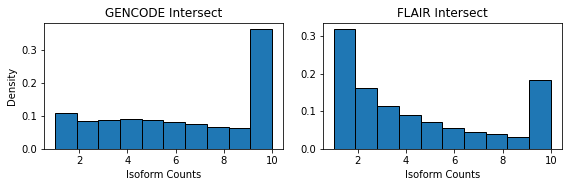

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2.7))


axes[0].set_title("GENCODE Intersect")
axes[0].set_xlabel("Isoform Counts")
axes[0].set_ylabel("Density")

axes[0].hist(gencode_int, density=True, edgecolor='black')


axes[1].set_title("FLAIR Intersect")
axes[1].set_xlabel("Isoform Counts")

axes[1].hist(flair_int, density=True, edgecolor='black')


plt.tight_layout()
plt.savefig("IntersectPlots.jpg", facecolor="white", dpi=300)
plt.show()

## Variants Per Gene, Per Tissue

In [11]:
# File names for each subject
fnames = [x for x in os.listdir("./GTEx_Analysis_v8_ASE_counts_by_subject/") if ".v8.ase_table." in x]

In [25]:
median_df_list = []
for fname in tqdm(fnames):
    df = pd.read_csv(f"./GTEx_Analysis_v8_ASE_counts_by_subject/{fname}", sep="\t")

    n_variants_df = df[["GENE_ID", "TISSUE_ID", "VARIANT_ID"]].groupby(["TISSUE_ID", "GENE_ID"]).size()
    n_variants_df = n_variants_df.reset_index().rename(columns={0: "N_VARIANTS"})

    med_variants_df = n_variants_df[["TISSUE_ID", "N_VARIANTS"]].groupby(["TISSUE_ID"]).median().transpose()

    median_df_list.append(med_variants_df)

100%|██████████| 838/838 [19:14<00:00,  1.38s/it]


In [27]:
median_tis = pd.concat(median_df_list)
median_tis

TISSUE_ID   ADPSBQ  BREAST  BRNACC  BRNCDT  BRNHPP  BRNHPT  LUNG  MSCLSK  \
N_VARIANTS     2.0     2.0     2.0     2.0     2.0     2.0   2.0     2.0   
N_VARIANTS     3.0     NaN     NaN     NaN     2.0     NaN   2.0     2.0   
N_VARIANTS     2.0     NaN     2.0     2.0     NaN     2.0   2.0     2.0   
N_VARIANTS     3.0     2.0     NaN     NaN     NaN     NaN   2.0     2.0   
N_VARIANTS     2.0     2.0     NaN     NaN     2.0     2.0   2.0     2.0   
...            ...     ...     ...     ...     ...     ...   ...     ...   
N_VARIANTS     2.0     NaN     NaN     NaN     NaN     NaN   NaN     2.0   
N_VARIANTS     2.0     NaN     NaN     NaN     NaN     NaN   2.0     2.0   
N_VARIANTS     2.0     NaN     NaN     NaN     2.0     2.0   1.0     2.0   
N_VARIANTS     NaN     NaN     NaN     NaN     NaN     NaN   NaN     NaN   
N_VARIANTS     2.0     2.0     NaN     NaN     NaN     NaN   2.0     2.0   

TISSUE_ID   NERVET  PTTARY  ...  SPLEEN  SLVRYG  SNTTRM  VAGINA  KDNCTX  \
N_VARIANTS     2.0     2.0  ...     NaN     NaN     NaN     NaN     NaN   
N_VARIANTS     2.0     2.0  ...     NaN     NaN     NaN     NaN     NaN   
N_VARIANTS     3.0     2.0  ...     NaN     NaN     NaN     NaN     NaN   
N_VARIANTS     3.0     NaN  ...     NaN     NaN     NaN     NaN     NaN   
N_VARIANTS     2.0     2.0  ...     NaN     NaN     NaN     NaN     NaN   
...            ...     ...  ...     ...     ...     ...     ...     ...   
N_VARIANTS     2.0     NaN  ...     NaN     NaN     NaN     NaN     NaN   
N_VARIANTS     2.0     NaN  ...     2.0     NaN     2.0     NaN     NaN   
N_VARIANTS     2.0     2.0  ...     NaN     NaN     NaN     NaN     NaN   
N_VARIANTS     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
N_VARIANTS     2.0     NaN  ...     NaN     NaN     NaN     NaN     NaN   

TISSUE_ID   KDNMDL  CVXECT  BLDDER  CVSEND  FLLPNT  
N_VARIANTS     NaN     NaN     NaN     NaN     NaN  
N_VARIANTS     NaN     NaN     NaN     NaN     NaN  
N_VARIANTS     NaN     NaN     NaN     NaN     NaN  
N_VARIANTS     NaN     NaN     NaN     NaN     NaN  
N_VARIANTS     NaN     NaN     NaN     NaN     NaN  
...            ...     ...     ...     ...     ...  
N_VARIANTS     NaN     NaN     NaN     NaN     NaN  
N_VARIANTS     NaN     NaN     NaN     NaN     NaN  
N_VARIANTS     NaN     NaN     NaN     NaN     NaN  
N_VARIANTS     NaN     NaN     NaN     NaN     NaN  
N_VARIANTS     NaN     2.0     2.0     2.0     2.0  

[838 rows x 54 columns]

In [86]:
median_tis_stats = pd.DataFrame(median_tis.mean()).reset_index().rename(columns={0:"mean"})
temp_df = pd.DataFrame(median_tis.std()).reset_index().rename(columns={0:"std"})

median_tis_stats = median_tis_stats.merge(temp_df)

median_tis_stats["lower_cb"] = median_tis_stats["mean"] - median_tis_stats["std"]
median_tis_stats["upper_cb"] = median_tis_stats["mean"] + median_tis_stats["std"]

median_tis_stats = median_tis_stats.merge(t_ss).sort_values("n_samples", ascending=False)

In [71]:
def per_tissue_cb(x, m, lcb, ucb):
    plt.plot([x, x], [lcb, ucb], color="red")
    plt.scatter(x, m, color="black")

    return

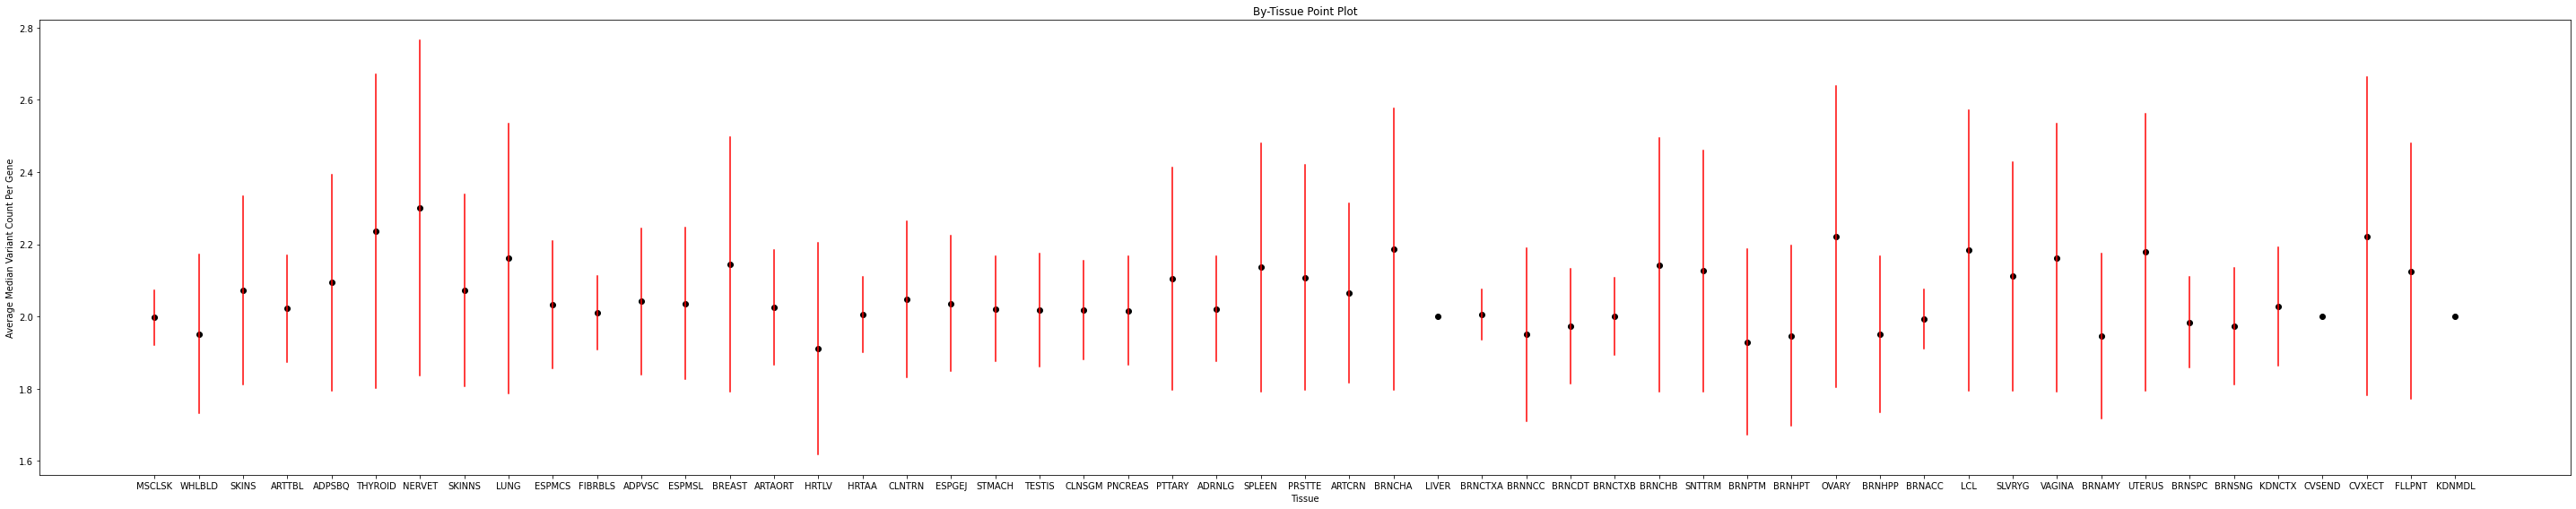

In [89]:
fig, ax = plt.subplots(figsize=(40, 8))

ax.set_xlabel("Tissue")
ax.set_ylabel("Average Median Variant Count Per Gene")
ax.set_title("By-Tissue Point Plot")

for i in range(len(median_tis_stats)):
    temp = median_tis_stats.iloc[i]

    tissue = temp["TISSUE_ID"]
    lcb = temp["lower_cb"]
    ucb = temp["upper_cb"]
    m = temp["mean"]
    
    per_tissue_cb(tissue, m, lcb, ucb)

plt.tight_layout()
plt.savefig("TissuePointPlot.png", facecolor="white")
plt.show()

In [32]:
# Initialize base dataframe to aggregate values
base_df = pd.DataFrame()

for fname in tqdm(fnames):
    df = pd.read_csv(f"./GTEx_Analysis_v8_ASE_counts_by_subject/{fname}", sep="\t")
    
    # Get variant counts by gene and tissue
    subset_df = df[["VARIANT_ID", "GENE_ID", "TISSUE_ID"]]
    gb_df = subset_df.groupby(["GENE_ID", "TISSUE_ID"]).size()
    gb_df = gb_df.reset_index().rename(columns={0:"n_vars"})

    # Concat with base_df and add together values.
    base_df = pd.concat([base_df, gb_df])
    base_df = base_df.groupby(["GENE_ID", "TISSUE_ID"]).sum().reset_index()

base_df.to_csv("./data/VariantCtByTissue.csv", index=False)

100%|██████████| 838/838 [27:57<00:00,  2.00s/it]


In [43]:
pd.DataFrame({"ABBR":list(set(base_df.TISSUE_ID))}).sort_values("ABBR").to_csv("tissue_names.csv", index=False)

In [76]:
df = pd.read_csv("./data/variant_sample_sizes.csv")
t_ss = pd.read_csv("./data/tissue_sample_sizes.csv")

In [54]:
tissue_stats = df[["TISSUE_ID", "n_vars"]].groupby("TISSUE_ID").mean().reset_index()
tissue_stats["std"] = df[["TISSUE_ID", "n_vars"]].groupby("TISSUE_ID").std().reset_index(drop=True).n_vars
#tissue_stats["std"] = tissue_stats.std()

In [ ]:
tissue_stats = tissue_stats.merge(t_ss, on="TISSUE_ID").sort_values("n_samples", ascending=False)
tissue_stat

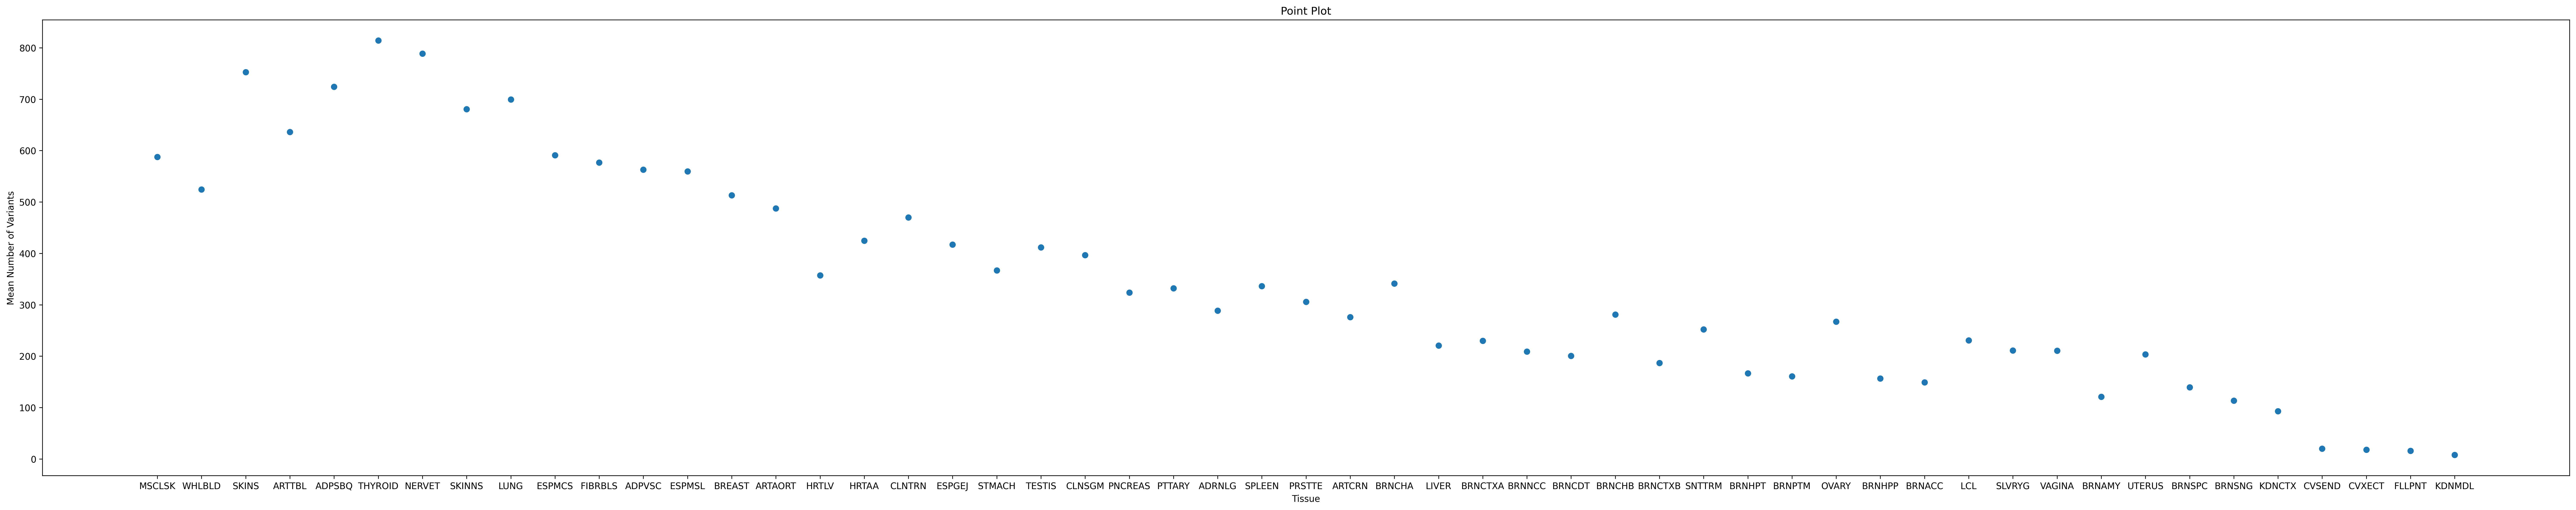

In [67]:
fig, ax = plt.subplots(figsize=(40,8), dpi=300)

ax.scatter(x=tissue_stats.TISSUE_ID, y=tissue_stats.n_vars)
ax.set_xlabel("Tissue")
ax.set_ylabel("Mean Number of Variants")
ax.set_title("Point Plot")

plt.tight_layout()
plt.savefig("MeanVariantsbyTissue.png", facecolor="white")
plt.show()

(array([5432., 1275.,  682., ...,    0.,    0.,    0.]),
 array([    0,    10,    20, ..., 25960, 25970, 25980]),
 <BarContainer object of 2598 artists>)

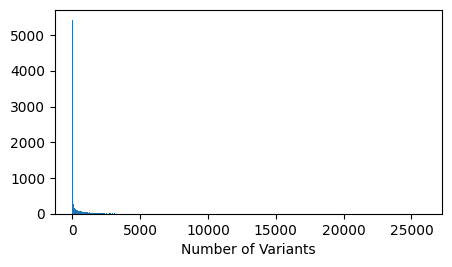

In [76]:
t_cts = df[df.TISSUE_ID == "MSCLSK"].n_vars

fig, ax = plt.subplots(figsize=(5, 2.7), dpi=100)
ax.set_xlabel('Number of Variants')
ax.hist(t_cts, bins=np.arange(0, max(t_cts), 10))

## Get all Short-read Sample to Tissue IDs

In [2]:
gtex_files = [x for x in os.listdir("./GTEx_Analysis_v8_ASE_counts_by_subject/") if "GTEX" in x]

full_samps = []
for gf in tqdm(gtex_files):
    gdf = pd.read_csv(f"./GTEx_Analysis_v8_ASE_counts_by_subject/{gf}", sep="\t")
    gdf = gdf[["SAMPLE_ID", "TISSUE_ID", "SUBJECT_ID"]].drop_duplicates()
    full_samps.append(gdf)

pd.concat(full_samps, axis=0)

100%|██████████| 838/838 [17:05<00:00,  1.22s/it]


SAMPLE_ID TISSUE_ID  SUBJECT_ID
0   GTEX-14LLW-2626-SM-62LDZ    SKINNS  GTEX-14LLW
2   GTEX-14LLW-0126-SM-6LLIO     SKINS  GTEX-14LLW
4   GTEX-14LLW-0326-SM-5ZZWD    NERVET  GTEX-14LLW
6   GTEX-14LLW-3026-SM-6EU1O    PTTARY  GTEX-14LLW
12  GTEX-14LLW-0626-SM-62LFC    BREAST  GTEX-14LLW
..                       ...       ...         ...
18   GTEX-S32W-0826-SM-4AD5Z   PNCREAS   GTEX-S32W
19   GTEX-S32W-2126-SM-2XCB1     SKINS   GTEX-S32W
20   GTEX-S32W-0726-SM-2XCBL   THYROID   GTEX-S32W
21   GTEX-S32W-1426-SM-4AD66    UTERUS   GTEX-S32W
33   GTEX-S32W-0006-SM-2XCAK    WHLBLD   GTEX-S32W

[15253 rows x 3 columns]

In [3]:
samp_data = pd.concat(full_samps, axis=0)
samp_data.to_csv("./data/sr_sample_tissue.csv", index=False)

## Filter by 5% transcript share

In [5]:
sample_tiss

TISSUE_ID SUBJECT_ID           2
0                     SAMPLE_ID  TISSUE_ID  SUBJECT_ID
1      GTEX-14LLW-2626-SM-62LDZ     SKINNS  GTEX-14LLW
2      GTEX-14LLW-0126-SM-6LLIO      SKINS  GTEX-14LLW
3      GTEX-14LLW-0326-SM-5ZZWD     NERVET  GTEX-14LLW
4      GTEX-14LLW-3026-SM-6EU1O     PTTARY  GTEX-14LLW
...                         ...        ...         ...
15249   GTEX-S32W-0826-SM-4AD5Z    PNCREAS   GTEX-S32W
15250   GTEX-S32W-2126-SM-2XCB1      SKINS   GTEX-S32W
15251   GTEX-S32W-0726-SM-2XCBL    THYROID   GTEX-S32W
15252   GTEX-S32W-1426-SM-4AD66     UTERUS   GTEX-S32W
15253   GTEX-S32W-0006-SM-2XCAK     WHLBLD   GTEX-S32W

[15254 rows x 3 columns]

In [10]:
# Get sample by tissue
sample_tiss = pd.read_csv('./data/sr_sample_tissue.csv')
tiss_dict = dict()
for tid in set(sample_tiss.TISSUE_ID):
    tiss_dict[tid] = list(sample_tiss[sample_tiss.TISSUE_ID == tid]["SAMPLE_ID"])
# Split up gct file into separate files by tissue

In [13]:
counter = 0
for k in tiss_dict.keys():
    counter += len(tiss_dict[k])

In [15]:
len(["transcript_id", "gene_id"] + tiss_dict["MSCLSK"])

708

In [17]:
for tid in tqdm(set(sample_tiss.TISSUE_ID)):
    tiss_df = pd.read_csv(
        "./data/short_read_transcript_counts.gct", sep = "\t", low_memory=True,
        skiprows=2,
        usecols=["transcript_id", "gene_id"] + tiss_dict[tid]
    )

    tiss_df.to_csv(f"./data/SR_transcript_counts_by_tissue/{tid}.csv", index=False)


100%|██████████| 54/54 [2:45:18<00:00, 183.67s/it]  


In [19]:
t_cts = pd.read_csv("./data/SR_transcript_counts_by_tissue/MSCLSK.csv")
t_cts["transcript_id"] = t_cts.transcript_id.str.split(".").str[0]
t_cts["gene_id"] = t_cts.gene_id.str.split(".").str[0]

In [21]:
samp_cols = [x for x in t_cts.columns if "GTEX" in x]
t_cts[samp_cols].sum(axis=1)

0         89979.16
1           127.74
2          5532.21
3         10975.56
4          1381.48
            ...   
199319        1.00
199320        0.00
199321        0.00
199322      165.75
199323        3.00
Length: 199324, dtype: float64

In [ ]:
def subset_sum(ss_cols, ind):
    for_colns = pd.read_csv("./short_read_transcript_counts.gct", sep = "\t", skiprows=2, usecols=ss_cols, low_memory=True)

    out_df = pd.concat([for_colns.iloc[:, :2], (for_colns[ss_cols[2:]] >= 1).sum(axis=1)], axis=1).rename(columns={0: "count"})

    out_df.to_csv(f"./data/intermed/{ind}.csv", index=False)

    return


subj_ids = pd.read_csv("./transcript_tpm.gct", sep = "\t", skiprows=2, nrows=0).columns
min_thresh = len([x for x in subj_ids if "GTEX" in x]) / 2

# Break up data into sets of 2000 columns for quicker loading
ss_cols_list = []
for n in range((len(subj_ids) // 2000) + 1):
    ss_cols_list.append(["transcript_id", "gene_id"] + list(subj_ids[2 + (n * 2000): min(((n * 2000) + 2 + 2000), len(subj_ids))]))

for i, ss_cols in enumerate(ss_cols_list):
    subset_sum(ss_cols, i)

## Filter by Highly Expressed Transcripts (TPM > 1)

In [ ]:
def subset_sum(ss_cols, ind):
    for_colns = pd.read_csv("./transcript_tpm.gct", sep = "\t", skiprows=2, usecols=ss_cols, low_memory=True)
    
    out_df = pd.concat([for_colns.iloc[:, :2], (for_colns[ss_cols[2:]] >= 1).sum(axis=1)], axis=1).rename(columns={0: "count"})
    
    out_df.to_csv(f"./data/intermed/{ind}.csv", index=False)

    return


subj_ids = pd.read_csv("./transcript_tpm.gct", sep = "\t", skiprows=2, nrows=0).columns
min_thresh = len([x for x in subj_ids if "GTEX" in x]) / 2

# Break up data into sets of 2000 columns for quicker loading
ss_cols_list = []
for n in range((len(subj_ids) // 2000) + 1):
    ss_cols_list.append(["transcript_id", "gene_id"] + list(subj_ids[2 + (n * 2000): min(((n * 2000) + 2 + 2000), len(subj_ids))]))

for i, ss_cols in enumerate(ss_cols_list):
    subset_sum(ss_cols, i)

In [85]:
samples = pd.read_csv("./data/sr-lr_sample_data.csv")
sr_samples = samples["SR_SAMPLE_ID"]

samp_cols = pd.read_csv("./transcript_tpm.gct", sep="\t", skiprows=2, usecols=sr_samples)
samp_cols

In [93]:
samp_cols.describe().transpose().reset_index().rename(columns={"index": "SUBJECT_ID"}).to_csv("sr_tpm_summary.csv", index=False)

In [85]:
for i in range(9):
    if i == 0:
        agg_counts = pd.read_csv(f"./data/intermed/{i}.csv")["count"]
    else:
        df = pd.read_csv(f"./data/intermed/{i}.csv")
        agg_counts = df["count"] + agg_counts

In [96]:
agg_df = pd.concat([pd.read_csv('./data/intermed/0.csv')[["transcript_id", "gene_id"]], agg_counts], axis=1)
passed = agg_df[agg_df["count"] >= min_thresh]

passed.transcript_id = passed.transcript_id.str.split(".").str[0]
passed.gene_id = passed.gene_id.str.split(".").str[0]

passed.to_csv("./data/filtered_transcripts.csv", index=False)

## Corroborating Long Read and Short Read

Counts Breakdown:
1. $\geq$1TPM & $\geq$50% of tissues: 36952
2. Isoform specific transcripts: 110753
3. Protein coding transcripts: 80464

Intersect: 13311

In [104]:
import pandas as pd

In [7]:
# FILTER 1: 1 TPM in 50% of tissues
passed = pd.read_csv("./data/filtered_transcripts.csv")

In [9]:
# FILTER 2: Isoform Specific
region_class = pd.read_csv("./data/pc_exon_region_classification2.csv")
iso_spec = region_class[region_class.transcript_count == 1][["transcript_ids"]].drop_duplicates()
iso_spec = iso_spec.rename(columns={"transcript_ids": "transcript_id"})

iso_pass = iso_spec.merge(passed)

In [10]:
iso_pass

transcript_id          gene_id  count
0      ENST00000294454  ENSG00000162461  13801
1      ENST00000375766  ENSG00000162458  10778
2      ENST00000509138  ENSG00000162458  11154
3      ENST00000483273  ENSG00000233954  16368
4      ENST00000375759  ENSG00000065526  17213
...                ...              ...    ...
15980  ENST00000471409  ENSG00000114374  11260
15981  ENST00000336079  ENSG00000067048  11549
15982  ENST00000472510  ENSG00000067048   9029
15983  ENST00000463199  ENSG00000067048   9644
15984  ENST00000361365  ENSG00000198692  11579

[15985 rows x 3 columns]

In [11]:
# FILTER 3: Protein Coding
pc_transc = pd.read_csv('./data/pc_gene_transcripts.csv')
pc_transc.transcript_id = pc_transc.transcript_id.str.split(";")
pc_transc = pc_transc.explode("transcript_id")

In [12]:
# Final list of valid transcripts
valid = iso_pass.merge(pc_transc, how="inner")
valid

transcript_id          gene_id  count
0      ENST00000294454  ENSG00000162461  13801
1      ENST00000375766  ENSG00000162458  10778
2      ENST00000483273  ENSG00000233954  16368
3      ENST00000375759  ENSG00000065526  17213
4      ENST00000428026  ENSG00000060656  14796
...                ...              ...    ...
13305  ENST00000373790  ENSG00000147133  16661
13306  ENST00000250784  ENSG00000129824  11627
13307  ENST00000430575  ENSG00000129824  11824
13308  ENST00000336079  ENSG00000067048  11549
13309  ENST00000361365  ENSG00000198692  11579

[13310 rows x 3 columns]

In [109]:
df = pd.read_csv("./data/quantification_gencode.tpm.tsv", sep="\t")
df["transcript"] = df.transcript.str.split(".").str[0]
df = df.rename(columns={"transcript": "transcript_id"})

# Get number of gtex samples to filter by
sample_ids = [x for x in df.columns if "GTEX" in x]

In [110]:
subject_data = pd.read_csv("./data/long_read_sample_data.csv")
subject_data = subject_data[subject_data.sample_name.str.contains("GTEX", regex=False)]
lr_samples = subject_data[["sample_name", "tissue"]].rename(columns={"sample_name": "SUBJECT_ID", "tissue": "TISSUE_ID"})

In [111]:
pd.read_csv("./data/long_read_samples_short.csv")

SUBJECT_ID TISSUE_ID
0   GTEX-1192X   BRNCTXB
1   GTEX-11H98    BRNCHB
2   GTEX-11TTK    BRNPTM
3   GTEX-1211K      LUNG
4   GTEX-1313W    BRNPTM
..         ...       ...
83   GTEX-S95S   FIBRBLS
84   GTEX-S95S   FIBRBLS
85   GTEX-S95S   FIBRBLS
86   GTEX-WY7C   FIBRBLS
87   GTEX-WY7C   FIBRBLS

[88 rows x 2 columns]

In [21]:
# lr_samples.to_csv("./data/long_read_samples_short.csv", index=False)

In [ ]:
gb_subj = lr_samples.groupby("SUBJECT_ID")
gps = list(gb_subj.groups.keys())
for subj in gps:
    try:
        subj_df = pd.read_csv(f"./GTEx_Analysis_v8_ASE_counts_by_subject/{subj}.v8.ase_table.tsv", sep="\t")
        tissues = list(gb_subj.get_group(subj)["TISSUE_ID"])
        for tissue in tissues:
            tissue_df = subj_df[subj_df.TISSUE_ID == tissue]
            tissue_df["COUNT"] = tissue_df.REF_COUNT + tissue_df.ALT_COUNT

    except FileNotFoundError:
        print(subj, "not found.")
        continue

## Compare Long Read counts with Short Read
### Outputs:
* `valid_lr_cts`: long-read counts of _**transcripts**_ intersected with filter-passing short-read transcripts
* `sr_lr_samples`: intersection of _**samples**_ between long and short reads

In [3]:
pc_transcripts = pd.read_csv("./data/protein_coding_transcripts.csv")# .rename(columns={"TRANSCRIPT_ID": "transcript_id", "GENE_ID": "gene_id"})

In [4]:
valid = pd.read_csv("./data/filtered_transcripts.csv").merge(pc_transcripts)

In [4]:
# Match up samples to compare counts' intersections
sr_samples = [x for x in os.listdir("./data/shortReadMappedShareFilteredPC/") if "GTEX" in x]

sr_subjs = []
sr_tissues = []
for sr_sample in sr_samples:
    splt = sr_sample.split("_")[0]
    both = splt.split("-")
    
    sr_subjs.append("-".join(both[0:2]))
    sr_tissues.append(both[-1])

sr_samples = pd.DataFrame({"SUBJECT_ID":sr_subjs, "TISSUE_ID":sr_tissues})

lr_samples = pd.read_csv("./data/long_read_sample_data.csv").rename(columns={"sample_id": "SAMPLE_ID",
                                                                            "sample_name": "SUBJECT_ID",
                                                                            "tissue": "TISSUE_ID"})[["SAMPLE_ID", "SUBJECT_ID", "TISSUE_ID"]]

# This dataframe is the intersection of samples between long and short reads
sr_lr_samples = lr_samples.merge(sr_samples)

In [5]:
# Get only the short-read filter-passing transcripts from long read
lr_cts = pd.read_csv("./data/long_read_counts.tsv", sep="\t")
lr_cts = lr_cts.rename(columns={"transcript": "transcript_id"})
lr_cts["transcript_id"] = lr_cts["transcript_id"].str.split(".").str[0]

In [10]:
valid_lr_cts = valid[["transcript_id", "gene_id"]].merge(lr_cts)

NameError: name 'valid' is not defined

In [6]:
all_corr = []
df_list = []
mean_sr = []
mean_lr = []
sd_sr = []
sd_lr = []

higher = []
lower = []
for i in range(len(sr_lr_samples)):
    samp, subj, tiss = sr_lr_samples.iloc[i]

    # Get filtered, isoform-specific, protein coding short-read mapped variants
    sr_df = pd.read_csv(f"./data/shortReadMappedShareFilteredPC/{subj}-{tiss}_variant_isospec.csv").dropna().rename(columns={"COUNT": "SR_COUNT"})
    # If a transcript has multiple variants take the mean
    sr_df = sr_df.groupby(["TISSUE_ID", "GENE_ID", "TRANSCRIPT_ID"])["SR_COUNT"].mean().reset_index()
    
    
    lr_df = lr_cts[lr_cts[samp] != 0].rename(columns={"transcript_id": "TRANSCRIPT_ID",
                                                                  samp:"LR_COUNT"})[["TRANSCRIPT_ID", "LR_COUNT"]]
    
    # Correlation between long and short reads
    shared_transc_cts = sr_df.merge(lr_df)
    df_list.append(shared_transc_cts)

    mean_sr.append(np.mean(shared_transc_cts.SR_COUNT))
    mean_lr.append(np.mean(shared_transc_cts.LR_COUNT))

    all_corr.append(shared_transc_cts.SR_COUNT.corr(shared_transc_cts.LR_COUNT))
    sd_sr.append(shared_transc_cts.SR_COUNT.std())
    sd_lr.append(shared_transc_cts.LR_COUNT.std())


    sr_sum = shared_transc_cts.LR_COUNT.describe()
    temp_low = shared_transc_cts[shared_transc_cts.LR_COUNT < sr_sum["50%"]]
    temp_hi = shared_transc_cts[shared_transc_cts.LR_COUNT >= sr_sum["50%"]]
    
    low_corr = temp_low.SR_COUNT.corr(temp_low.LR_COUNT); lower.append(low_corr)
    hi_corr = temp_hi.SR_COUNT.corr(temp_hi.LR_COUNT); higher.append(hi_corr)

    #print("Full:", shared_transc_cts.SR_COUNT.corr(shared_transc_cts.LR_COUNT))
    #print("Lower:", low_corr)
    #print("Higher:", hi_corr, end="\n\n")

In [7]:
corr_samples = sr_lr_samples.copy()
corr_samples["CORR"] = all_corr
corr_samples["MEAN_SR"] = mean_sr
corr_samples["MEAN_LR"] = mean_lr
corr_samples["STD_SR"] = sd_sr
corr_samples["STD_LR"] = sd_lr

corr_sum = pd.Series(all_corr).describe(); display(corr_sum)

count    83.000000
mean      0.496250
std       0.218519
min       0.039068
25%       0.318948
50%       0.453268
75%       0.691091
max       0.899815
dtype: float64

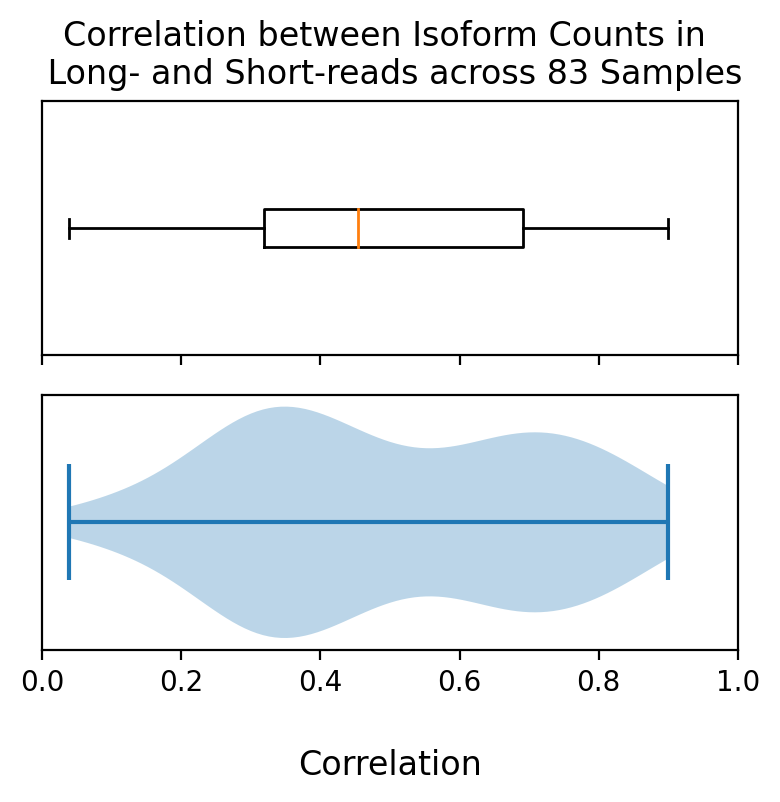

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(4, 4), dpi=200)

axes[0].boxplot(pd.Series(all_corr), vert=False)
axes[0].set_yticks([])
axes[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], [])
axes[0].set_title("Correlation between Isoform Counts in \n Long- and Short-reads across 83 Samples")
axes[0].set_xlim(0, 1)

axes[1].violinplot(pd.Series(all_corr), vert=False)
axes[1].set_yticks([])
axes[1].set_xlim(0, 1)

fig.supxlabel("Correlation")

plt.tight_layout()
# plt.savefig("corr_box_violin.jpg", dpi=500)
plt.show()

In [33]:
pd.Series(all_corr).describe()

count    83.000000
mean      0.496250
std       0.218519
min       0.039068
25%       0.318948
50%       0.453268
75%       0.691091
max       0.899815
dtype: float64

In [13]:
def rsq(x, y):
    a, b = np.polyfit(x, y, 1)
    
    x = np.array(x); y = np.array(y)
    fit = x*a + b
    y_bar = np.mean(y)
    
    ssr = np.sum((y - fit)**2)
    sst = np.sum((y - y_bar)**2)

    return 1 - ssr/sst

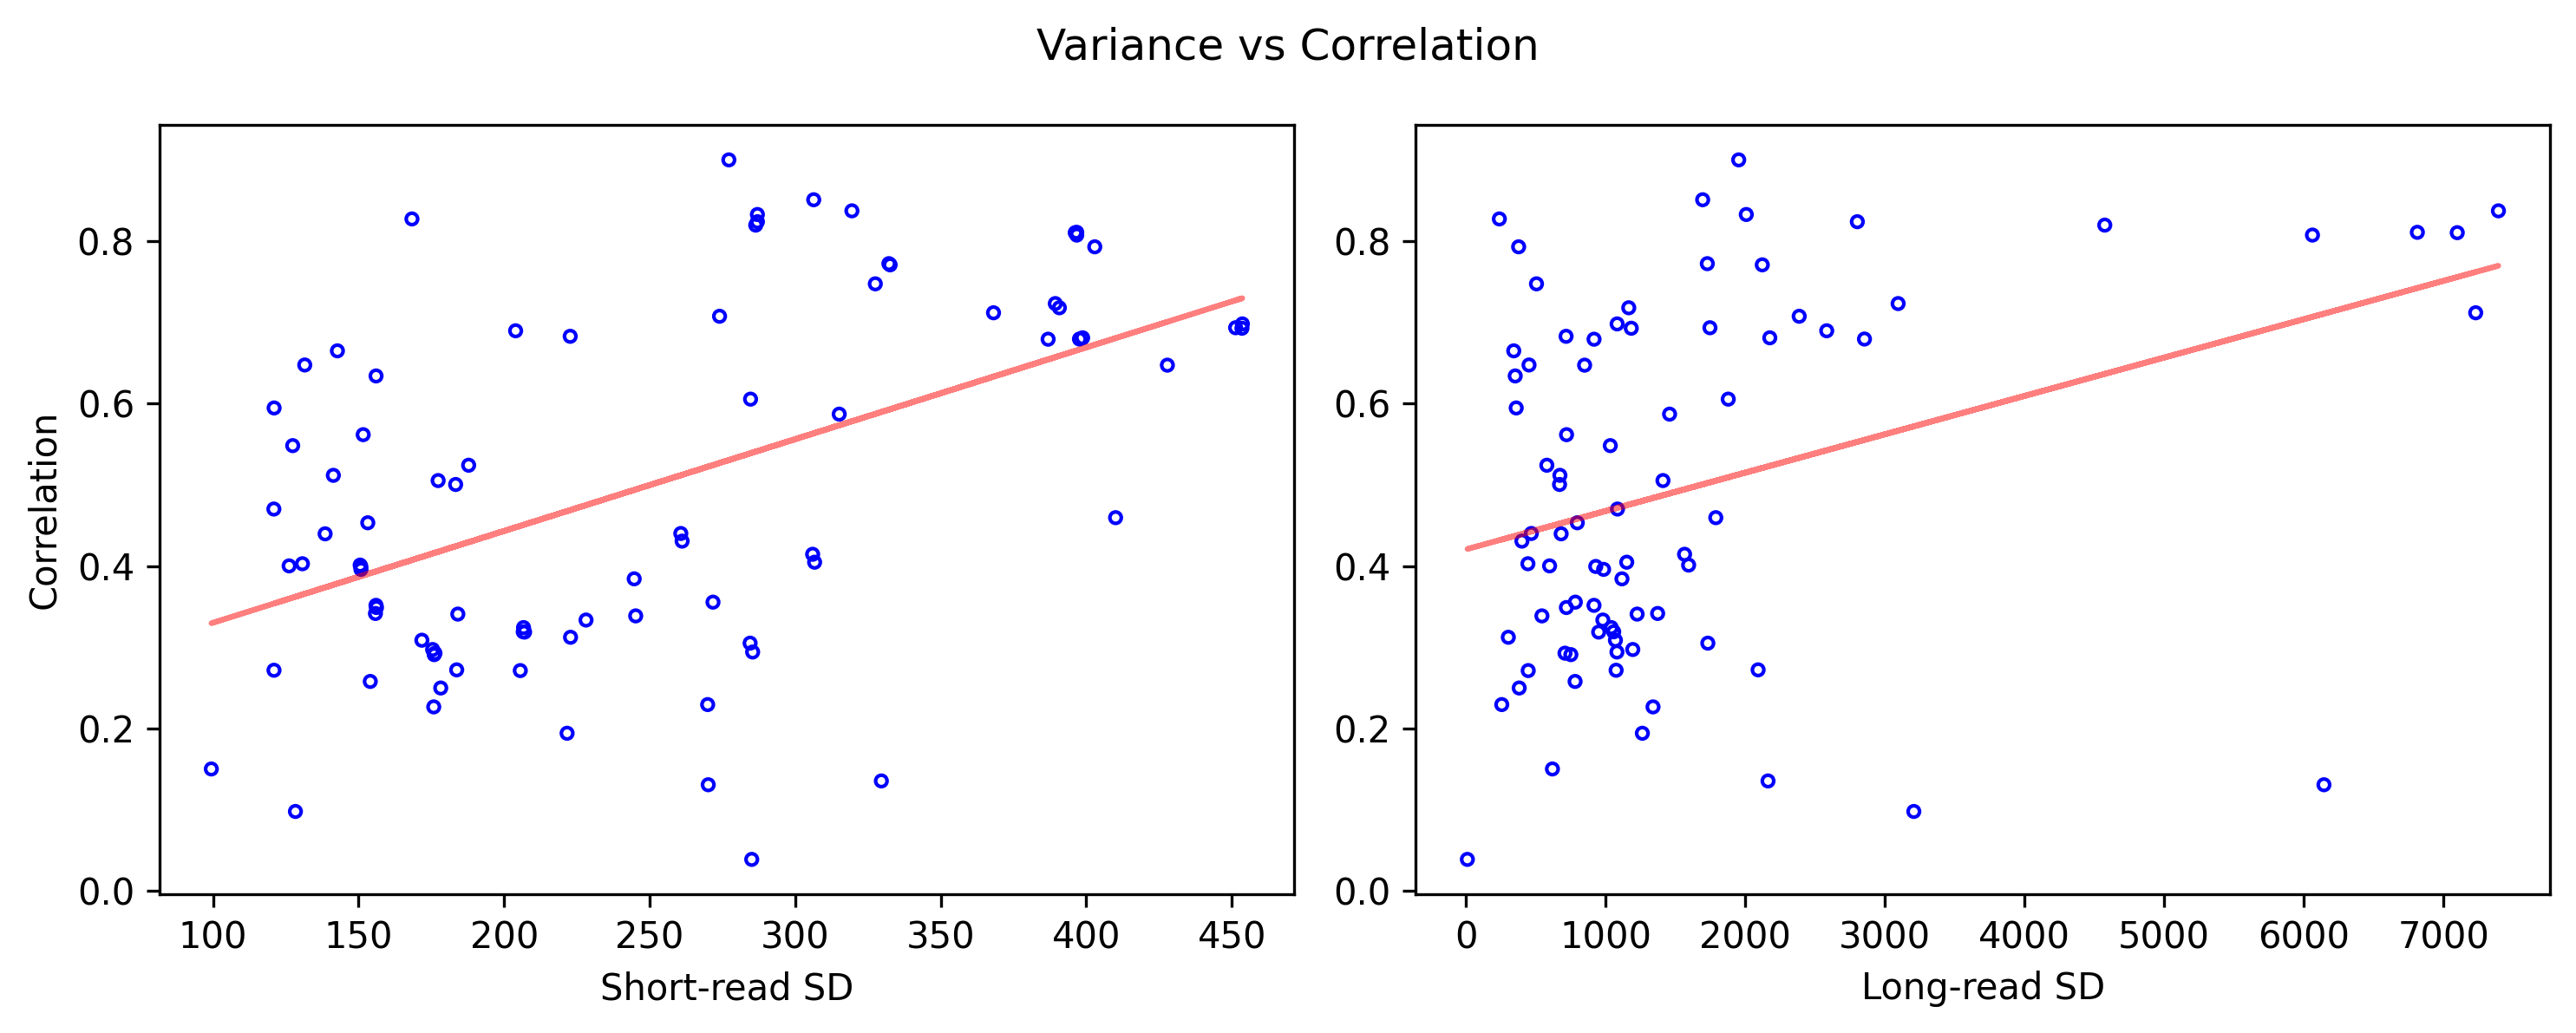

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=300)

axes[0].scatter(corr_samples.STD_SR, corr_samples.CORR, facecolors='none', edgecolors='b', s=10)
axes[1].scatter(corr_samples.STD_LR, corr_samples.CORR, facecolors='none', edgecolors='b', s=10)

axes[0].set_xlabel("Short-read SD")
axes[1].set_xlabel("Long-read SD")

sr_a, sr_b = np.polyfit(corr_samples.STD_SR, corr_samples.CORR, 1)
lr_a, lr_b = np.polyfit(corr_samples.STD_LR, corr_samples.CORR, 1)

axes[0].plot(corr_samples.STD_SR, corr_samples.STD_SR * sr_a + sr_b, color="red", alpha=0.5)
axes[1].plot(corr_samples.STD_LR, corr_samples.STD_LR * lr_a + lr_b, color="red", alpha=0.5)

axes[0].set_ylabel("Correlation")
fig.suptitle("Variance vs Correlation")

plt.tight_layout()
plt.show()

In [15]:
lt_50 = corr_samples[corr_samples.CORR <= corr_sum["25%"]]
gt_50 = corr_samples[corr_samples.CORR >= corr_sum["75%"]]

In [16]:
print(lt_50.MEAN_SR.mean(), lt_50.MEAN_LR.mean())
print(gt_50.MEAN_SR.mean(), gt_50.MEAN_LR.mean())

68.55549645479826 234.87387014753438
77.17949946345773 274.8869298331396


In [3]:
def plot_corr(df_list, i, ax, log=False):
    df = df_list[i]
    _, subj_id, tissue_id, corr, mean_sr, mean_lr, _, _ = corr_samples.iloc[i]
    
    ax.set_xlabel("Short Read")
    ax.set_ylabel("Long Read")
    if log:
        ax.set_xscale("log")
        ax.set_yscale("log")
        # a, b = np.polyfit(np.log10(df.SR_COUNT), np.log10(df.LR_COUNT), 1)
        a, b = np.polyfit(df.SR_COUNT, df.LR_COUNT, 1)
        ax.annotate(f"r={np.round(df.SR_COUNT.corr(df.LR_COUNT), 3)}", xy=(0.75, 0.9), xycoords='axes fraction')
        # ax.annotate(f"r={np.round(np.log10(df.SR_COUNT).corr(np.log10(df.LR_COUNT)), 3)}", xy=(0.75, 0.9), xycoords='axes fraction')
        
    else:
        a, b = np.polyfit(df.SR_COUNT, df.LR_COUNT, 1)
        ax.annotate(f"r={np.round(df.SR_COUNT.corr(df.LR_COUNT), 3)}", xy=(0.75, 0.9), xycoords='axes fraction')

    # ax.set_xlim(0, 2500); ax.set_ylim(0, 2500)
    ax.set_title(f"{subj_id}: {tissue_id}")
    ax.set_xlim(0, 500)
    ax.set_ylim(0, 1000)

    ax.scatter(df.SR_COUNT, df.LR_COUNT, s=1.5, facecolors="none", linewidths=0.3, edgecolors="blue")
    ax.plot(df.SR_COUNT.sort_values(), a*df.SR_COUNT.sort_values() + b, color="r", linestyle="--", alpha=0.5)
    return ax

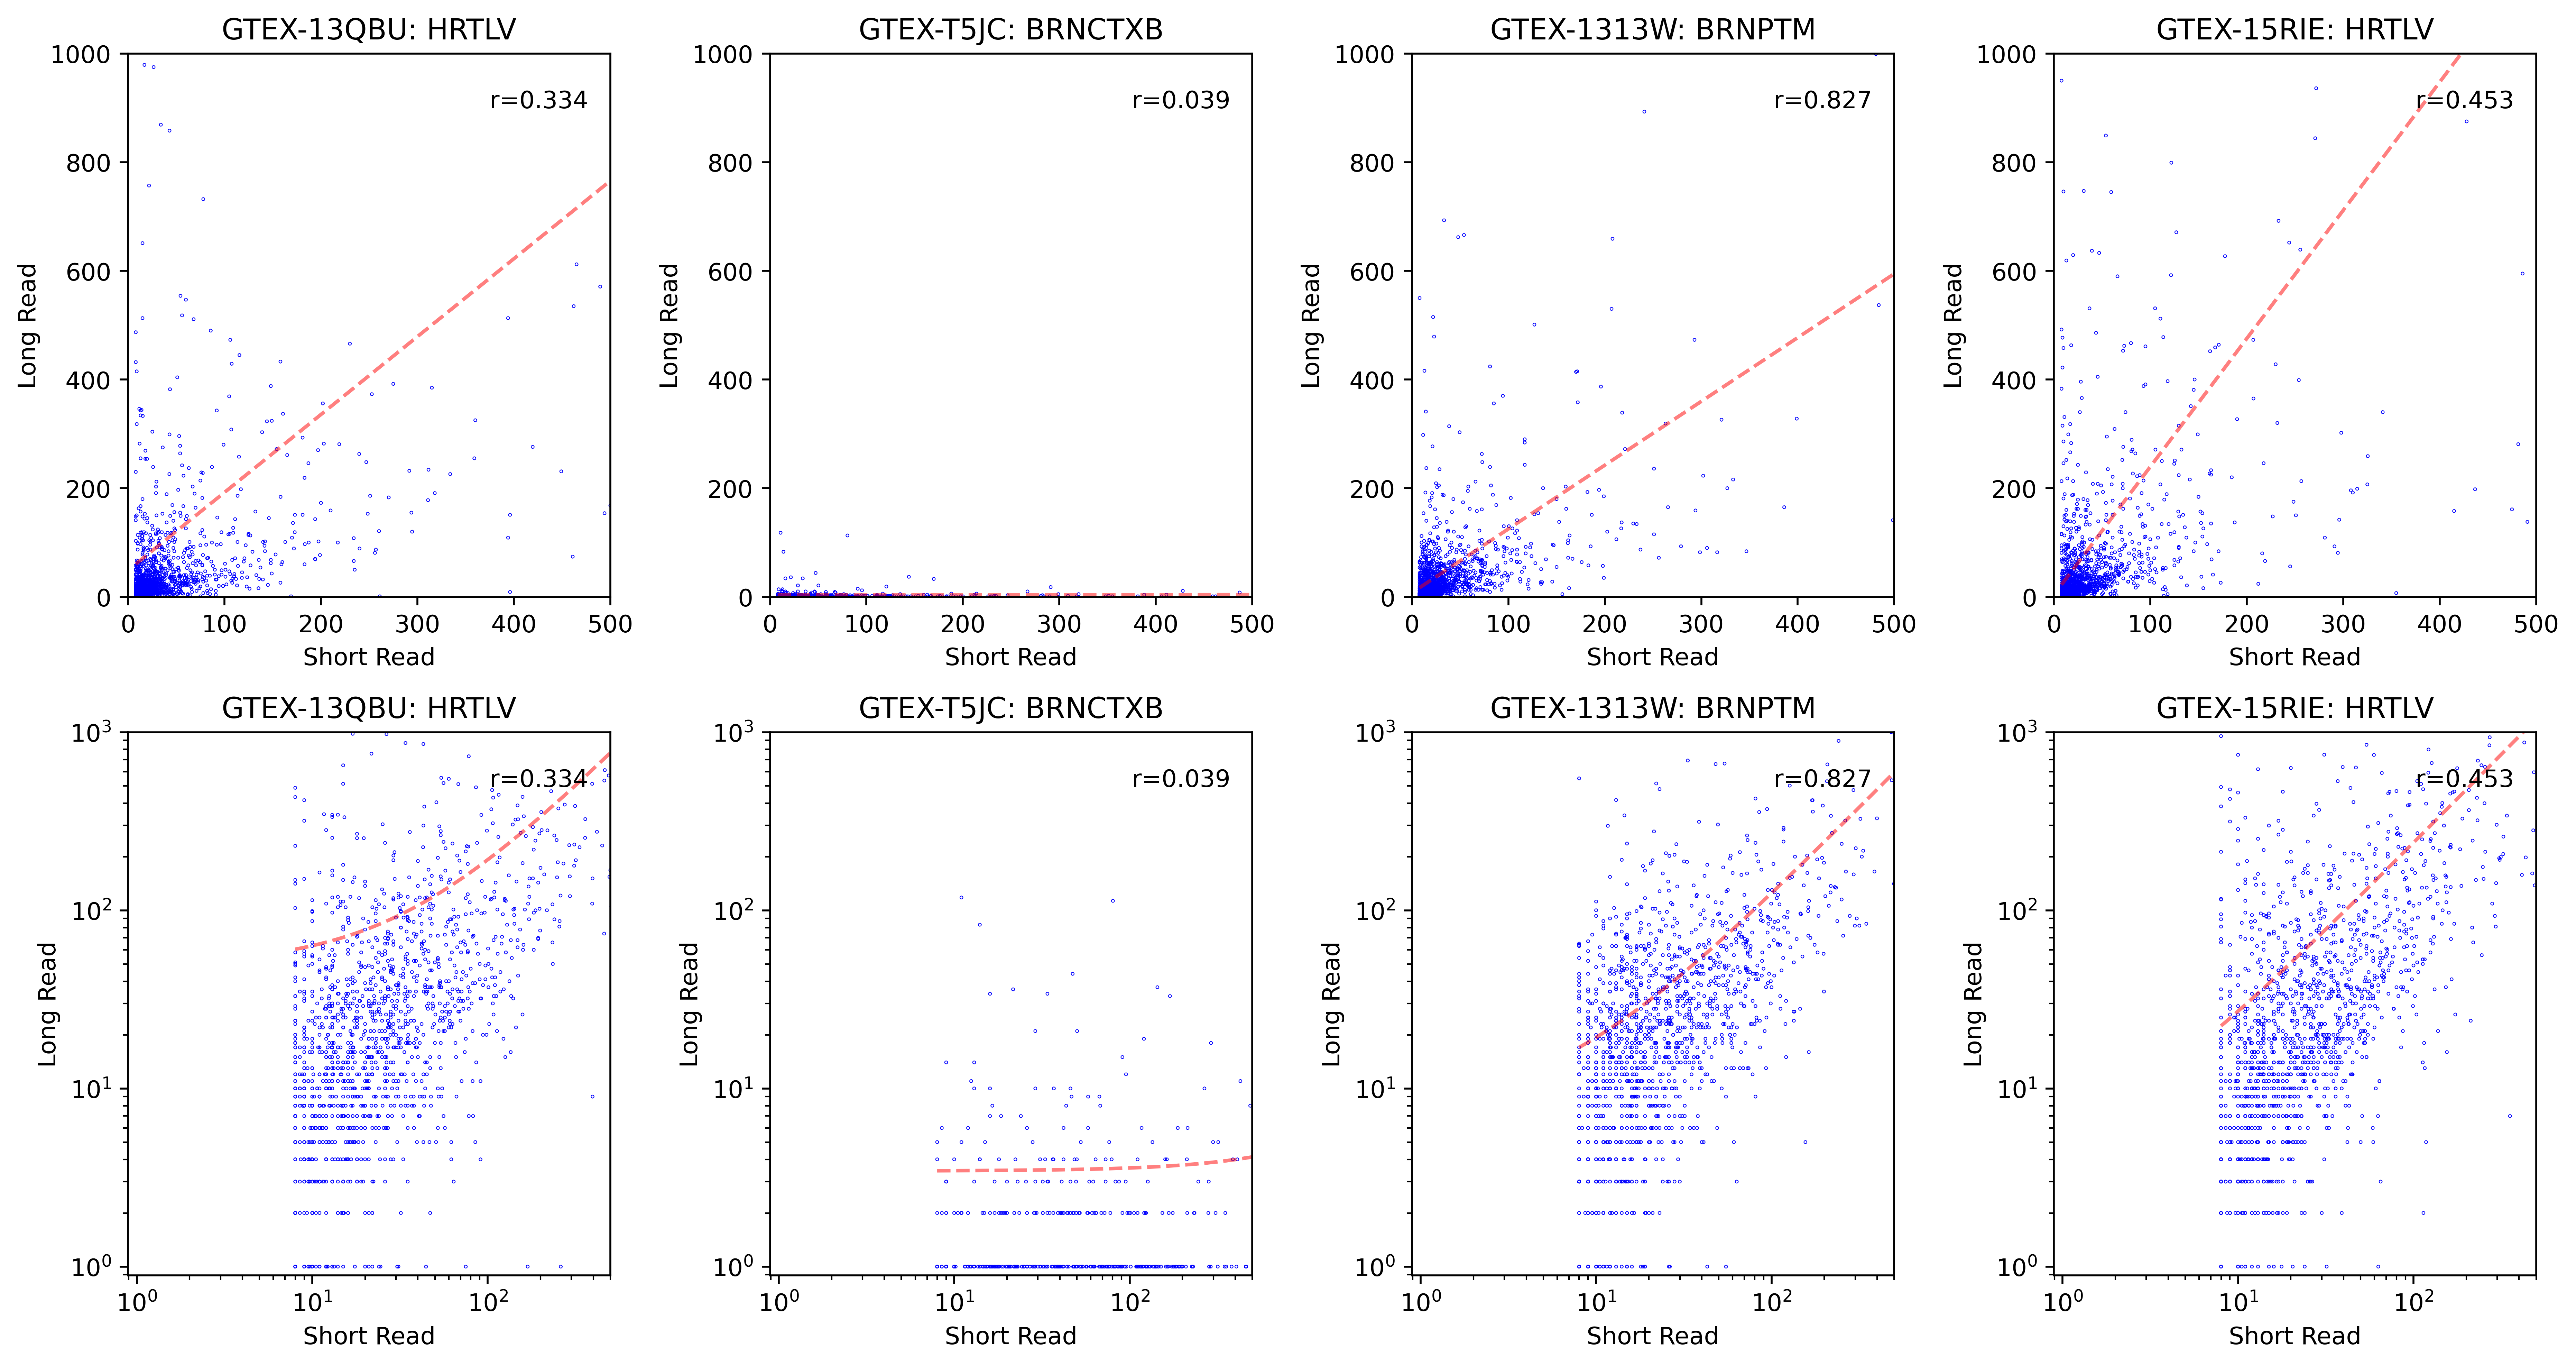

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8), dpi=500)
plot_corr(df_list, 4, axes[0, 0])
plot_corr(df_list, 50, axes[0, 1])
plot_corr(df_list, 3, axes[0, 2])
plot_corr(df_list, 20, axes[0, 3])
plot_corr(df_list, 4, axes[1, 0], log=True)
plot_corr(df_list, 50, axes[1, 1], log=True)
plot_corr(df_list, 3, axes[1, 2], log=True)
plot_corr(df_list, 20, axes[1, 3], log=True)
plt.tight_layout()
plt.show()

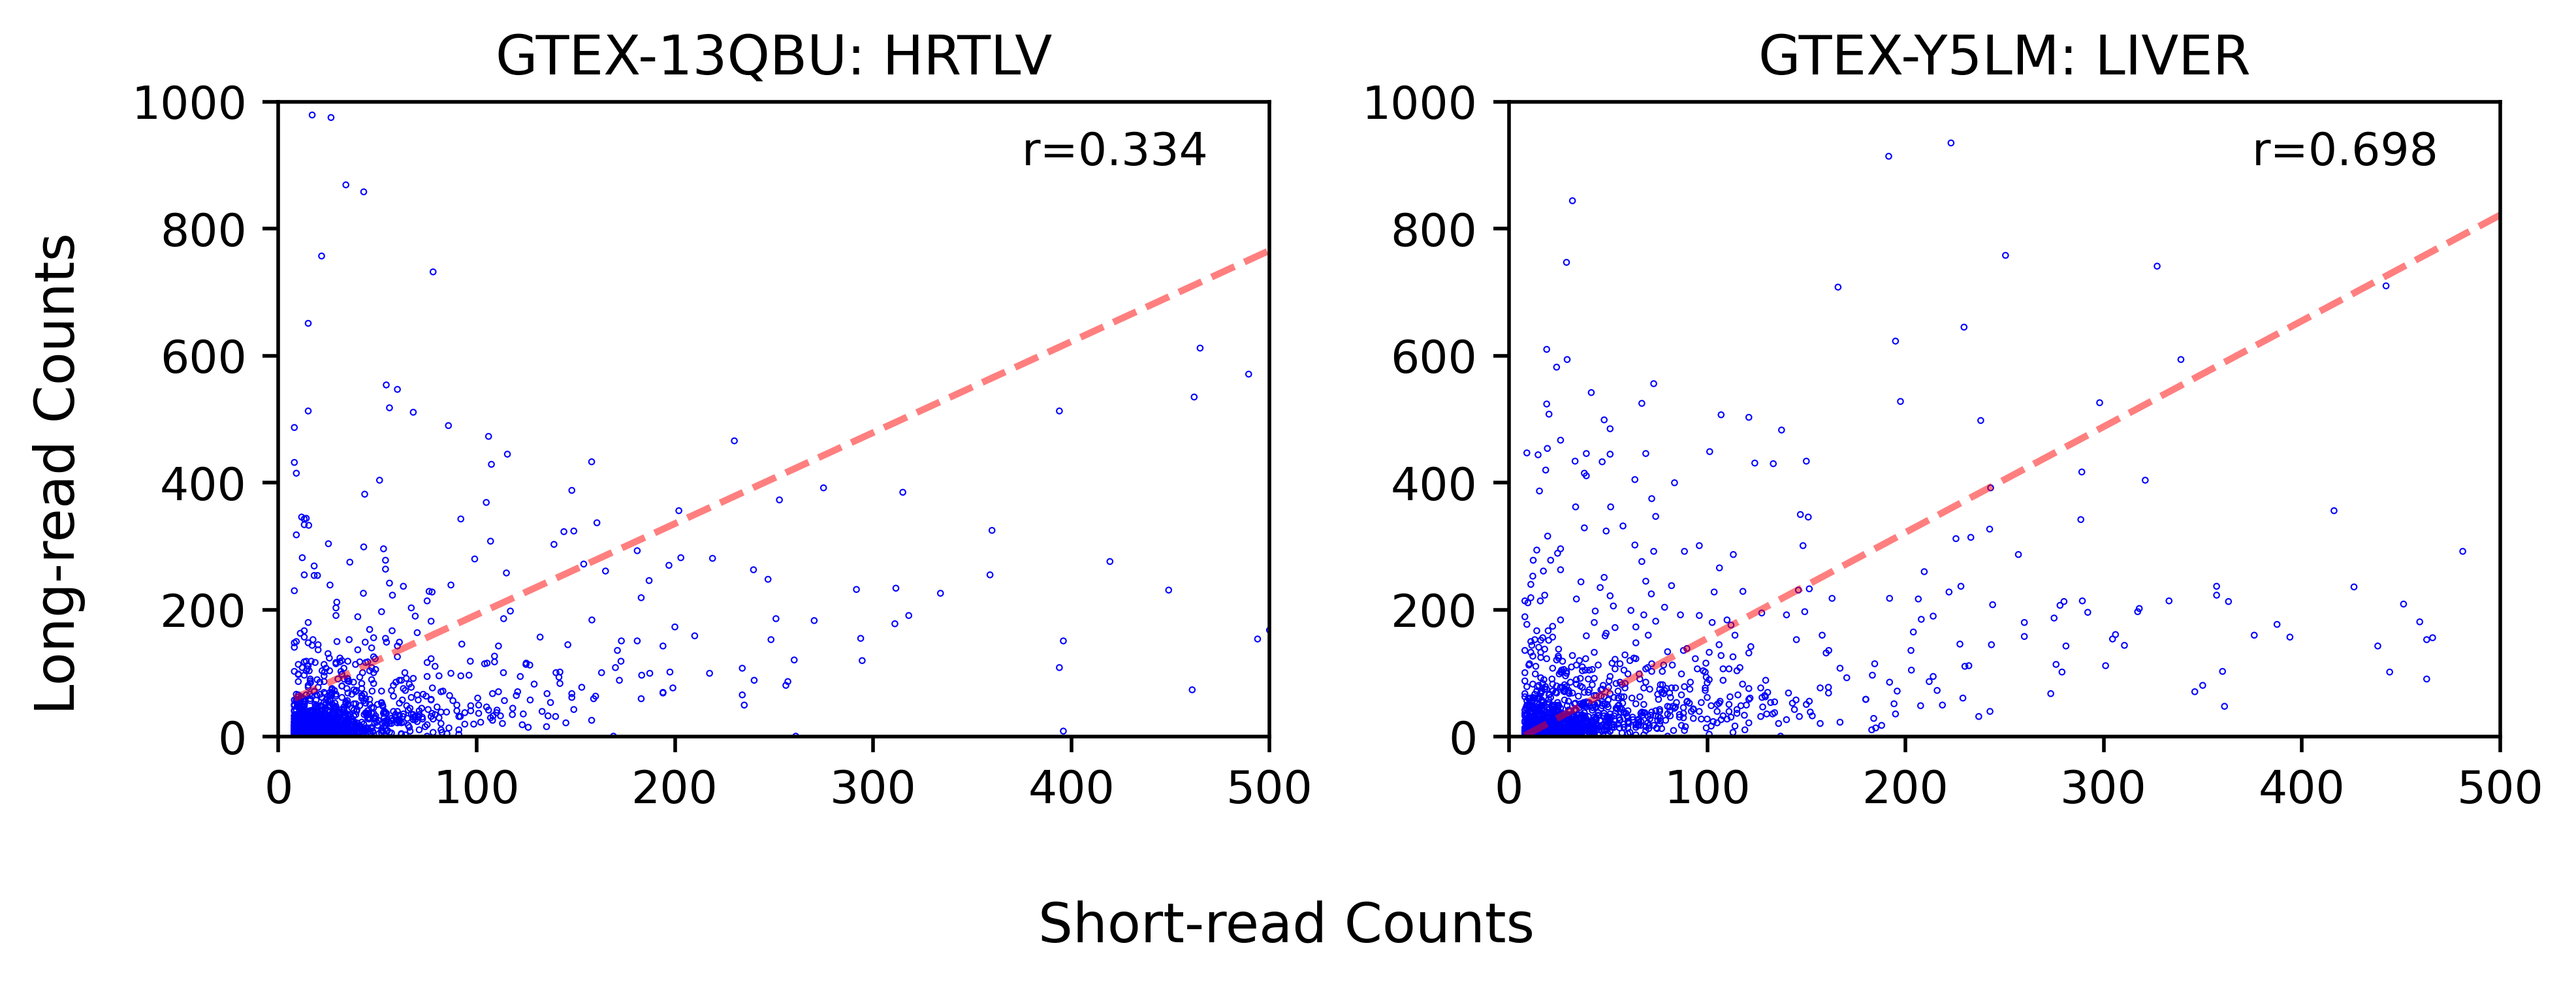

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=500)
plot_corr(df_list, 4, axes[0])
plot_corr(df_list, 60, axes[1])

axes[0].set_ylabel(None)
axes[1].set_ylabel(None)
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)

fig.supylabel("Long-read Counts")
fig.supxlabel("Short-read Counts")

plt.tight_layout()
plt.savefig("./corr_example.jpg", dpi=500)
plt.show()

## Histogram Plots
### Requires: [`flair_df_transc`](#another_cell)
Features:
* Protein coding short reads
* Short reads with $\geq$1TPM in $\geq$50% of tissues
* Long reads intersected with filter-passing, protein coding short reads (joined on gene, not transcript)

In [245]:
pri_exons = pd.read_csv("./data/pcPriExons.csv")
gene_transc = pri_exons[["gene_id", "transcript_id"]].drop_duplicates().merge(pc_transcripts)
transc_ct = gene_transc.groupby("gene_id").size().reset_index().rename(columns={0: "transcript_count"})

In [246]:
# Limit to protein coding?
pc_genes = pri_exons[["gene_id"]].drop_duplicates()
flair_df_transc = flair_df_transc.merge(pc_genes, how="inner")

In [251]:
# FLAIR transcript counts
flair_cts = flair_df_transc[["gene_id", "transcript_id"]].drop_duplicates().groupby("gene_id")["transcript_id"].size()
flair_cts = flair_cts.reset_index().rename(columns={"transcript_id": "transcript_count"})

In [252]:
# Short Read TPM and in 50% tissues
passed = pd.read_csv("./data/filtered_transcripts.csv")
tpm_pass = passed.groupby("gene_id")["transcript_id"].size().reset_index().rename(columns={"transcript_id": "transcript_count"})

In [260]:
tpm_pass

gene_id  transcript_count
0      ENSG00000000003                 1
1      ENSG00000000419                 2
2      ENSG00000000457                 2
3      ENSG00000000938                 3
4      ENSG00000000971                 3
...                ...               ...
13921  ENSG00000284128                 1
13922  ENSG00000284294                 1
13923  ENSG00000284308                 1
13924  ENSG00000284428                 1
13925  ENSG00000284461                 1

[13926 rows x 2 columns]

In [253]:
sr_lr_filtered = tpm_pass.merge(flair_cts, on="gene_id", suffixes=("_sr", "_lr"))

sr_sym_dif = pd.DataFrame({"gene_id":list(set(tpm_pass.gene_id).symmetric_difference(sr_lr_filtered.gene_id))})
lr_sym_dif = pd.DataFrame({"gene_id":list(set(flair_cts.gene_id).symmetric_difference(sr_lr_filtered.gene_id))})

sr_exclusive = tpm_pass.merge(sr_sym_dif)
lr_exclusive = flair_cts.merge(lr_sym_dif)

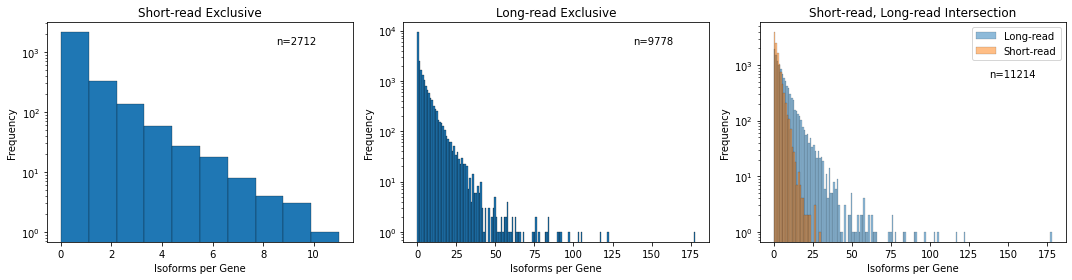

In [261]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Short Read Exclusive transcripts
# fig, ax = plt.subplots(figsize=(5, 3), dpi=500)

axes[0].set_xlabel("Isoforms per Gene")
axes[0].set_ylabel("Frequency")
axes[0].set_title(r"Short-read Exclusive")
axes[0].set_yscale("log")
axes[0].annotate(f"n={sr_exclusive.shape[0]}", xy=(0.75, 0.90), xycoords='axes fraction')

max_val = sr_exclusive.transcript_count.max()
axes[0].hist(sr_exclusive["transcript_count"], edgecolor="black", linewidth=0.25, bins=np.linspace(0, max_val, max_val))


# Long Read Flair Exclusive transcripts
# fig, ax = plt.subplots(figsize=(5, 3), dpi=500)

axes[1].set_xlabel("Isoforms per Gene")
axes[1].set_ylabel("Frequency")
axes[1].set_title(r"Long-read Exclusive")
axes[1].set_yscale("log")
axes[1].annotate(f"n={lr_exclusive.shape[0]}", xy=(0.75, 0.90), xycoords='axes fraction')

max_val = flair_cts.transcript_count.max()
axes[1].hist(flair_cts["transcript_count"], edgecolor="black", linewidth=0.25, bins=np.linspace(0, max_val, max_val))

# Intersection of flair and short read
# fig, ax = plt.subplots(figsize=(5, 3), dpi=500)

axes[2].set_xlabel("Isoforms per Gene")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Short-read, Long-read Intersection")
axes[2].set_yscale("log")
axes[2].annotate(f"n={sr_lr_filtered.shape[0]}", xy=(0.75, 0.75), xycoords='axes fraction')

max_val_sr = sr_lr_filtered.transcript_count_sr.max()
max_val_lr = sr_lr_filtered.transcript_count_lr.max()

axes[2].hist(sr_lr_filtered["transcript_count_lr"], edgecolor="black", linewidth=0.25,
               bins=np.linspace(0, max_val_lr, max_val_lr), alpha=0.5, label="Long-read")
axes[2].hist(sr_lr_filtered["transcript_count_sr"], edgecolor="black", linewidth=0.25,
               bins=np.linspace(0, max_val_sr, max_val_sr), alpha=0.5, label="Short-read")

axes[2].legend(loc="best")

plt.tight_layout()

plt.savefig("./sr_lr_hists.jpg", dpi=500)
plt.show()

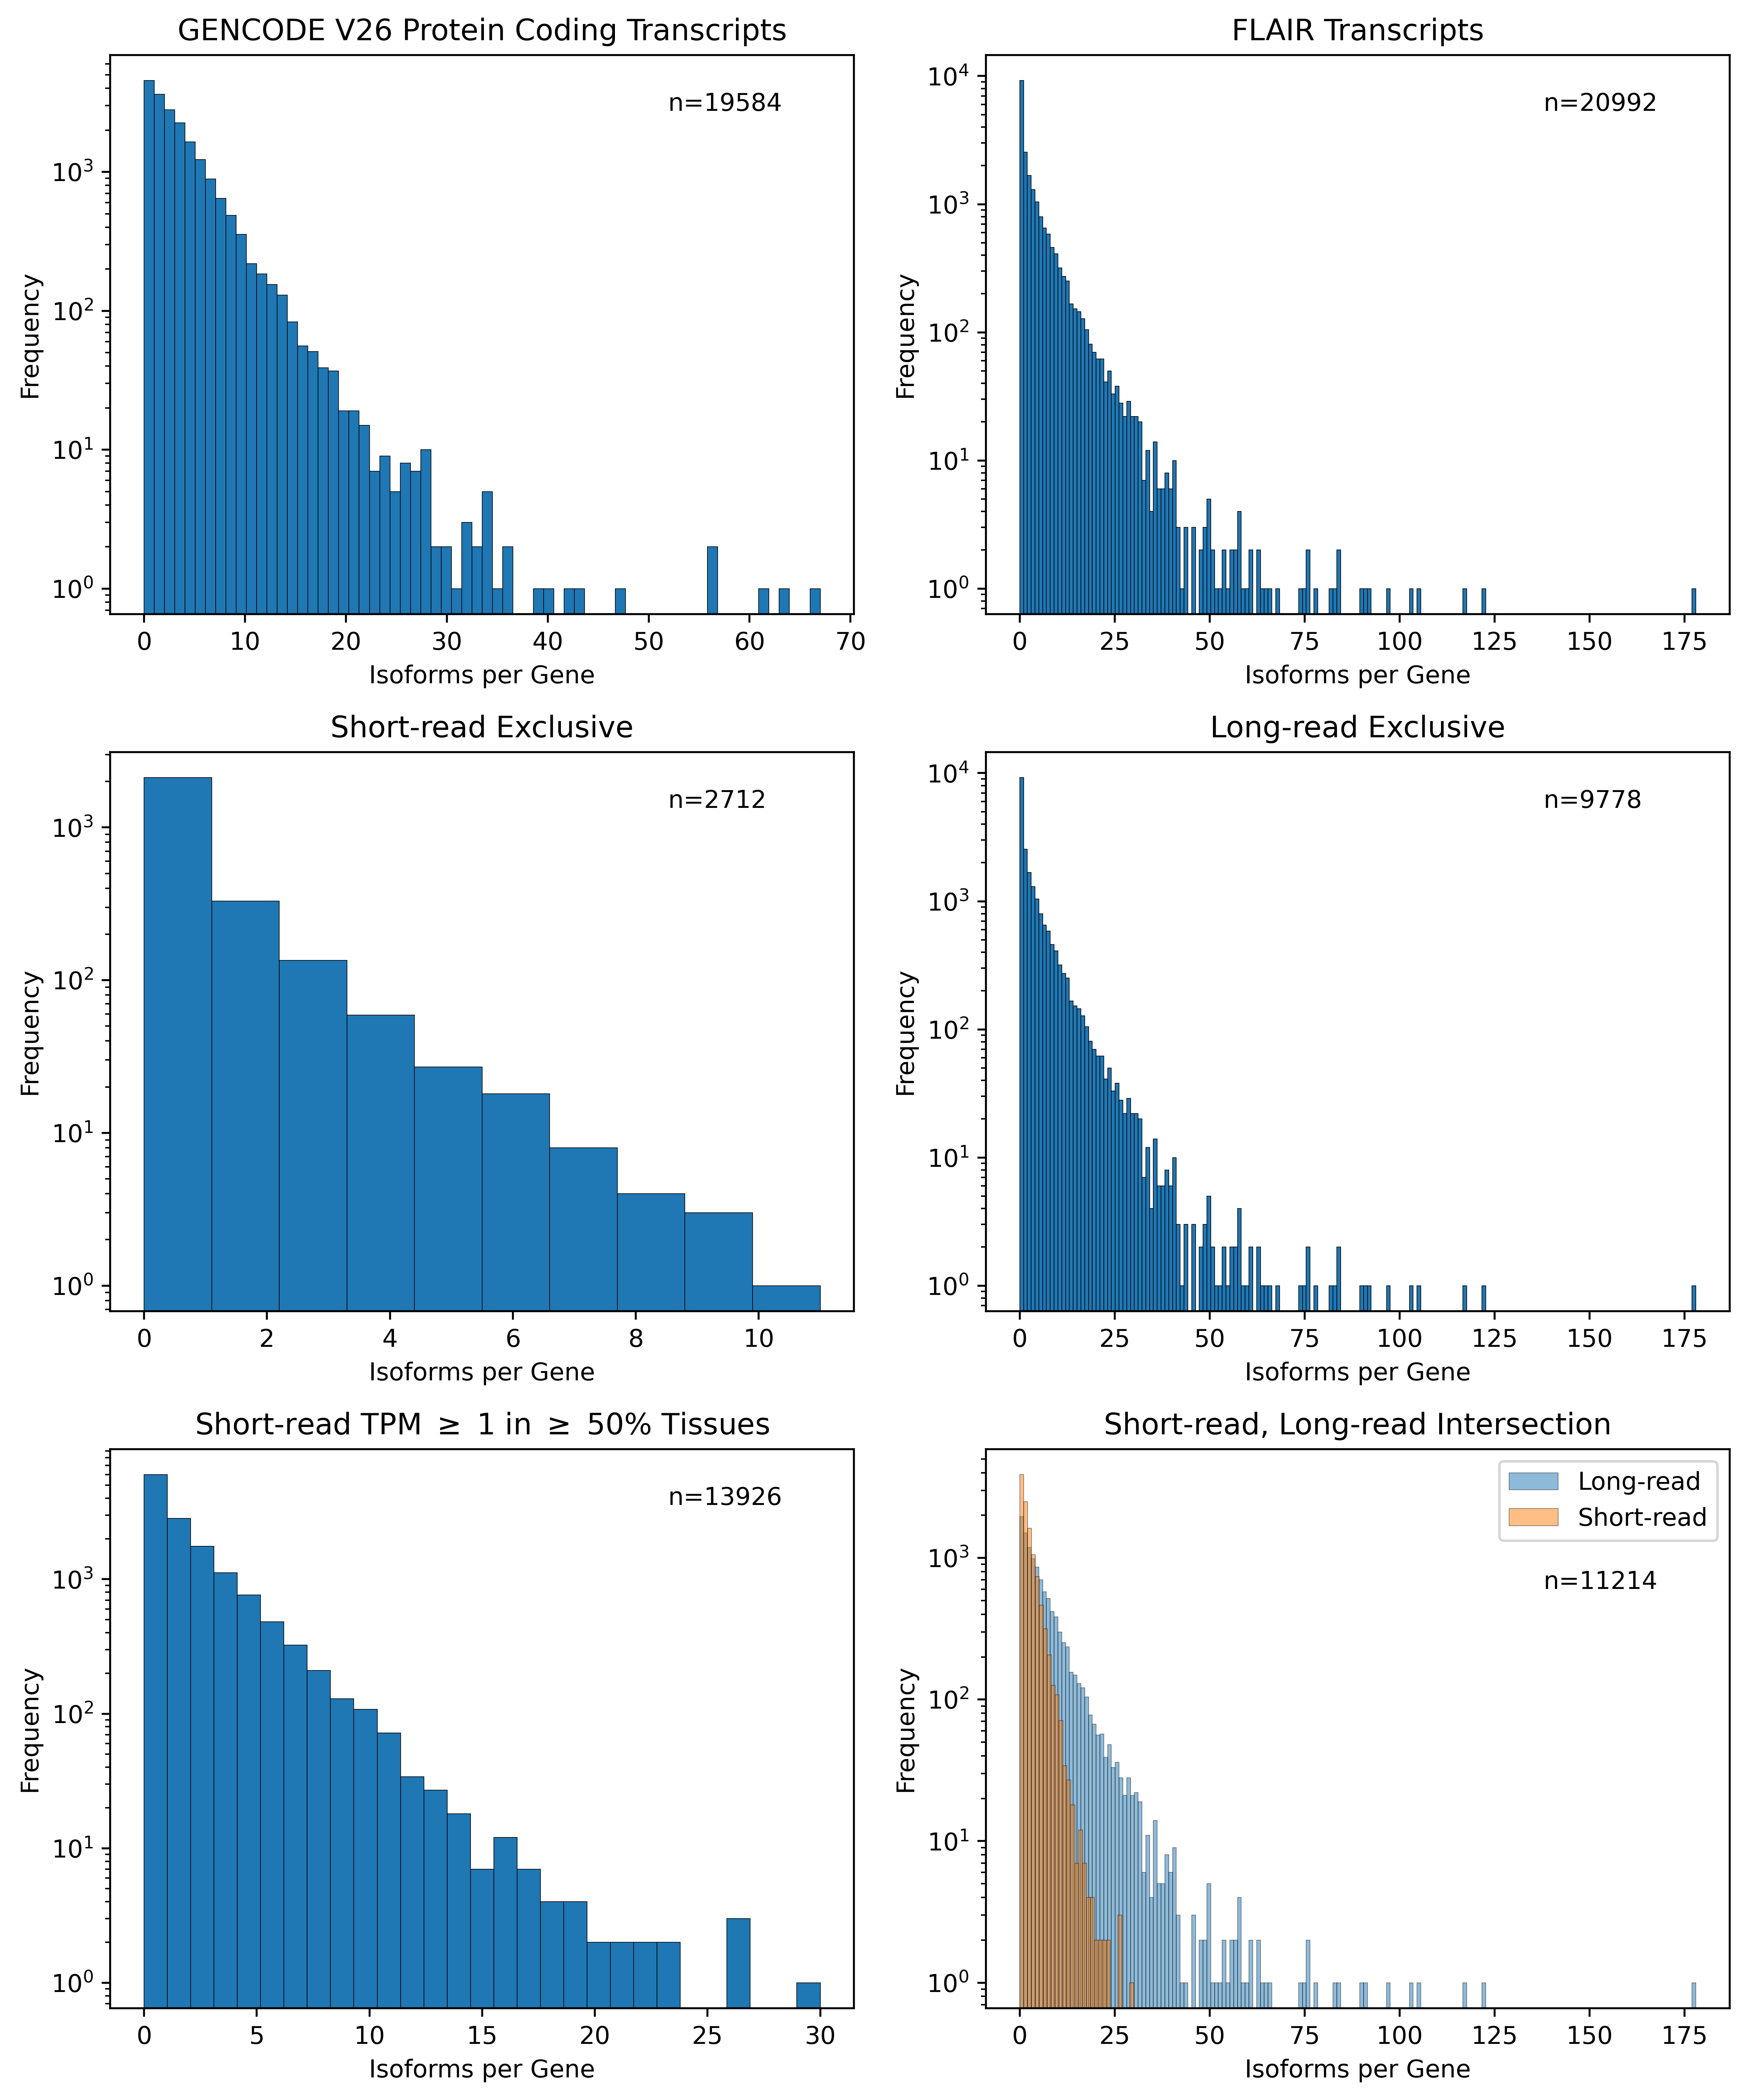

In [256]:
fig, axes = plt.subplot_mosaic([["A", "B"], ["C", "D"], ["E", "F"]], figsize=(10, 12), dpi=500)

# GENCODE 26 Short Reads
# fig, ax = plt.subplots(figsize=(5, 3), dpi=500)

axes["A"].set_xlabel("Isoforms per Gene")
axes["A"].set_ylabel("Frequency")
axes["A"].set_title("GENCODE V26 Protein Coding Transcripts")
axes["A"].set_yscale("log")
axes["A"].annotate(f"n={transc_ct.shape[0]}", xy=(0.75, 0.90), xycoords='axes fraction')

max_val = transc_ct.transcript_count.max()
axes["A"].hist(transc_ct["transcript_count"], edgecolor="black", linewidth=0.25, bins=np.linspace(0, max_val, max_val))


# Flair Annotations
# fig, ax = plt.subplots(figsize=(5, 3), dpi=500)

axes["B"].set_xlabel("Isoforms per Gene")
axes["B"].set_ylabel("Frequency")
axes["B"].set_title(r"FLAIR Transcripts")
axes["B"].set_yscale("log")
axes["B"].annotate(f"n={flair_cts.shape[0]}", xy=(0.75, 0.90), xycoords='axes fraction')

max_val = flair_cts.transcript_count.max()
axes["B"].hist(flair_cts["transcript_count"], edgecolor="black", linewidth=0.25, bins=np.linspace(0, max_val, max_val))


# Short Read Exclusive transcripts
# fig, ax = plt.subplots(figsize=(5, 3), dpi=500)

axes["C"].set_xlabel("Isoforms per Gene")
axes["C"].set_ylabel("Frequency")
axes["C"].set_title(r"Short-read Exclusive")
axes["C"].set_yscale("log")
axes["C"].annotate(f"n={sr_exclusive.shape[0]}", xy=(0.75, 0.90), xycoords='axes fraction')

max_val = sr_exclusive.transcript_count.max()
axes["C"].hist(sr_exclusive["transcript_count"], edgecolor="black", linewidth=0.25, bins=np.linspace(0, max_val, max_val))


# Long Read Flair Exclusive transcripts
# fig, ax = plt.subplots(figsize=(5, 3), dpi=500)

axes["D"].set_xlabel("Isoforms per Gene")
axes["D"].set_ylabel("Frequency")
axes["D"].set_title(r"Long-read Exclusive")
axes["D"].set_yscale("log")
axes["D"].annotate(f"n={lr_exclusive.shape[0]}", xy=(0.75, 0.90), xycoords='axes fraction')

max_val = flair_cts.transcript_count.max()
axes["D"].hist(flair_cts["transcript_count"], edgecolor="black", linewidth=0.25, bins=np.linspace(0, max_val, max_val))


# Short Read filter-passing
# fig, ax = plt.subplots(figsize=(5, 3), dpi=500)

axes["E"].set_xlabel("Isoforms per Gene")
axes["E"].set_ylabel("Frequency")
axes["E"].set_title(r"Short-read TPM $\geq$ 1 in $\geq$ 50% Tissues")
axes["E"].set_yscale("log")
axes["E"].annotate(f"n={tpm_pass.shape[0]}", xy=(0.75, 0.90), xycoords='axes fraction')

max_val = tpm_pass.transcript_count.max()
axes["E"].hist(tpm_pass["transcript_count"], edgecolor="black", linewidth=0.25, bins=np.linspace(0, max_val, max_val))


# Intersection of flair and short read
# fig, ax = plt.subplots(figsize=(5, 3), dpi=500)

axes["F"].set_xlabel("Isoforms per Gene")
axes["F"].set_ylabel("Frequency")
axes["F"].set_title("Short-read, Long-read Intersection")
axes["F"].set_yscale("log")
axes["F"].annotate(f"n={sr_lr_filtered.shape[0]}", xy=(0.75, 0.75), xycoords='axes fraction')

max_val_sr = sr_lr_filtered.transcript_count_sr.max()
max_val_lr = sr_lr_filtered.transcript_count_lr.max()

axes["F"].hist(sr_lr_filtered["transcript_count_lr"], edgecolor="black", linewidth=0.25,
               bins=np.linspace(0, max_val_lr, max_val_lr), alpha=0.5, label="Long-read")
axes["F"].hist(sr_lr_filtered["transcript_count_sr"], edgecolor="black", linewidth=0.25,
               bins=np.linspace(0, max_val_sr, max_val_sr), alpha=0.5, label="Short-read")

axes["F"].legend(loc="best")

plt.tight_layout()
plt.show()

In [20]:
len(os.listdir("./data/LR_ASE"))

54

In [27]:
def btest(row):
    x = row["REF_COUNT_SR"]
    n = row["ALT_COUNT_SR"] + row["REF_COUNT_SR"]
    p = row["RATIO_LR"]
    
    return(binom_test(x, n, p))

In [28]:
def get_lr_ase(subj_id, tiss_id, high_power=False):
    # Load and preprocess long-read
    name_map = {
        "Transcript": "TRANSCRIPT_ID",
        "Ref_count": "REF_COUNT",
        "Alt_count": "ALT_COUNT",
        "Chrom": "CHR",
        "Position": "POS",
        "Ref": "REF",
        "Alt": "ALT"
               }
    lr_df = pd.read_csv(f"./data/LR_ASE/{subj_id}_{tiss_id}.tsv", sep="\t").rename(columns=name_map)
    lr_df["TRANSCRIPT_ID"] = lr_df.TRANSCRIPT_ID.str.split(".").str[0]

    lr_gb = lr_df.groupby("TRANSCRIPT_ID")

    lr_ref = lr_gb["REF_COUNT"].mean()
    lr_alt = lr_gb["ALT_COUNT"].mean()

    lr_df = lr_ref.reset_index().merge(lr_alt.reset_index())
    lr_df["RATIO"] = lr_df["REF_COUNT"] / (lr_df["REF_COUNT"] + lr_df["ALT_COUNT"])
    if high_power:
        lr_df = lr_df[(lr_df.REF_COUNT + lr_df.ALT_COUNT) > 100]
    
    return lr_df

In [29]:
def get_sr_ase(subj_id, tiss_id, high_power=False):
    # Load and preprocess short-read
    sr_df = pd.read_csv(f"./data/shortReadMappedShareFilteredPC/{subj_id}-{tiss_id}_variant_isospec.csv").dropna()

    if high_power:
        sr_df = sr_df[sr_df.COUNT >= 100]

    sr_gb = sr_df.groupby("TRANSCRIPT_ID")

    sr_ref = sr_gb["REF_COUNT"].mean()
    sr_alt = sr_gb["ALT_COUNT"].mean()

    sr_df = sr_ref.reset_index().merge(sr_alt.reset_index())
    sr_df["RATIO"] = sr_df["REF_COUNT"] / (sr_df["REF_COUNT"] + sr_df["ALT_COUNT"])
    
    return sr_df

In [55]:
def fe_test(row):
    cont_table = np.array([[row.REF_COUNT_SR, row.REF_COUNT_LR], [row.ALT_COUNT_SR, row.ALT_COUNT_LR]])
    return fisher_exact(cont_table, alternative='two-sided')[1]

In [57]:
test = "fisher_exact"
for i in tqdm(range(len(sr_lr_samples))):
    samp_id, subj_id, tiss_id = sr_lr_samples.iloc[i]

    try:
        lr_df = get_lr_ase(subj_id, tiss_id, high_power=False)
        sr_df = get_sr_ase(subj_id, tiss_id, high_power=True)
    except FileNotFoundError:
        continue

    ase_df = sr_df.merge(lr_df, on="TRANSCRIPT_ID", suffixes=["_SR", "_LR"])
    if test == "fisher_exact":
        ase_df["PVALUE"] = ase_df.apply(lambda x: fe_test(x), axis=1)
        ase_df.to_csv(f"./data/ShareSRLRASE_FETest/{subj_id}_{tiss_id}.csv", index=False)
        
    else:
        ase_df["PVALUE"] = ase_df.apply(btest, axis=1)
        ase_df.to_csv(f"./data/ShareSRLRASEBinomTest/{subj_id}_{tiss_id}.csv", index=False)

100%|██████████| 83/83 [03:21<00:00,  2.43s/it]


In [ ]:
subj_id = "GTEX-13RTJ"
tiss_id = "BRNPTM"
btest_df = pd.read_csv(f"./data/SRLRASEBinomTest/{subj_id}_{tiss_id}.csv")

In [323]:
tdf = pd.read_csv("./data/filtered_transcripts.csv")

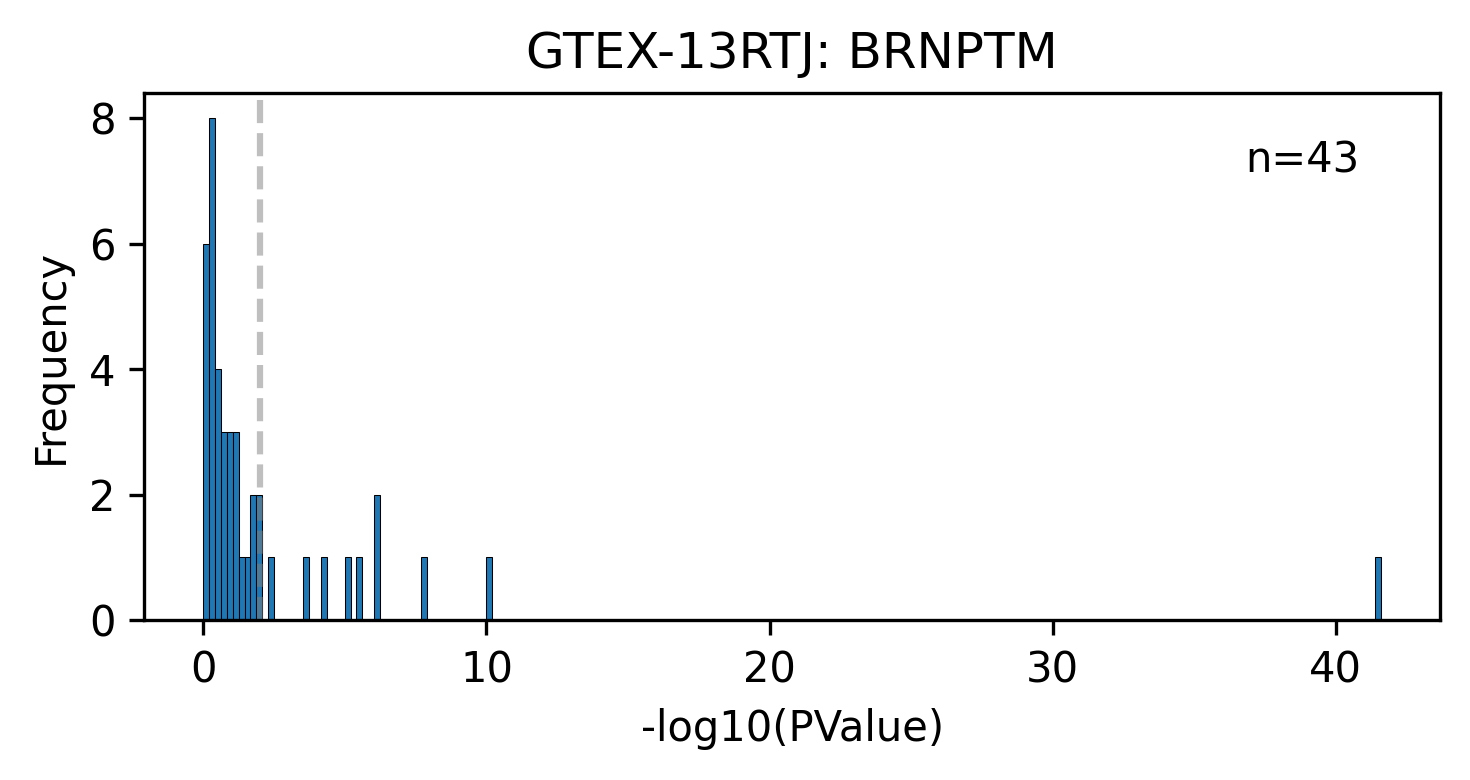

In [321]:
fig, ax = plt.subplots(figsize=(5, 2.7), dpi=300)

ax.hist(-np.log10(btest_df["PVALUE"]), bins=200, edgecolor="black", linewidth=0.25)
ax.set_xlabel("-log10(PValue)")
ax.set_ylabel("Frequency")
ax.set_title(f"{subj_id}: {tiss_id}")
ax.annotate(f"n={btest_df.shape[0]}", xy=(0.85, 0.85), xycoords='axes fraction')
ax.axvline(x=-np.log10(0.01), color="grey", alpha=0.5, linestyle="--")

plt.tight_layout()
plt.show()

In [62]:
df

TRANSCRIPT_ID  REF_COUNT_SR  ALT_COUNT_SR  RATIO_SR  REF_COUNT_LR  \
0    ENST00000003912         129.5    124.000000  0.510848     19.000000   
1    ENST00000078429          84.5     81.000000  0.510574     15.333333   
2    ENST00000165698         129.0    111.000000  0.537500     51.000000   
3    ENST00000187762          55.0     68.000000  0.447154     48.000000   
4    ENST00000215095         181.0    141.333333  0.561531     60.000000   
..               ...           ...           ...       ...           ...   
166  ENST00000615612         116.5     88.000000  0.569682     41.000000   
167  ENST00000617998          87.0     69.000000  0.557692     23.000000   
168  ENST00000619039         127.6    139.400000  0.477903     47.500000   
169  ENST00000619168         113.6    107.800000  0.513098     30.500000   
170  ENST00000621914         243.0    194.000000  0.556064     16.000000   

     ALT_COUNT_LR  RATIO_LR    PVALUE  
0       39.000000  0.327586  0.013334  
1       13.333333  0.534884  0.840153  
2       60.500000  0.457399  0.206535  
3       60.000000  0.444444  1.000000  
4       53.333333  0.529412  0.583746  
..            ...       ...       ...  
166     27.000000  0.602941  0.671901  
167     19.000000  0.547619  1.000000  
168     34.000000  0.582822  0.127649  
169     35.500000  0.462121  0.483029  
170     24.000000  0.400000  0.068261  

[171 rows x 8 columns]

In [3]:
# path = "./data/SRLRASEBinomTest/"
path = "./data/ShareSRLRASE_FETest/"
all_tot = []
all_sig = []
for file in [x for x in os.listdir(path) if "GTEX" in x]:
    df = pd.read_csv(path+file)
    df["PVALUE"] = multipletests(list(df["PVALUE"]), method="fdr_bh")[1]
    
    tot = df.shape[0]
    sig_df = df[df.PVALUE <= 0.05]
    sig = sig_df.shape[0]

    all_tot.append(tot)
    all_sig.append(sig)

In [4]:
sig_df = pd.DataFrame({
    "TOTAL": all_tot,
    "SIG": all_sig
})

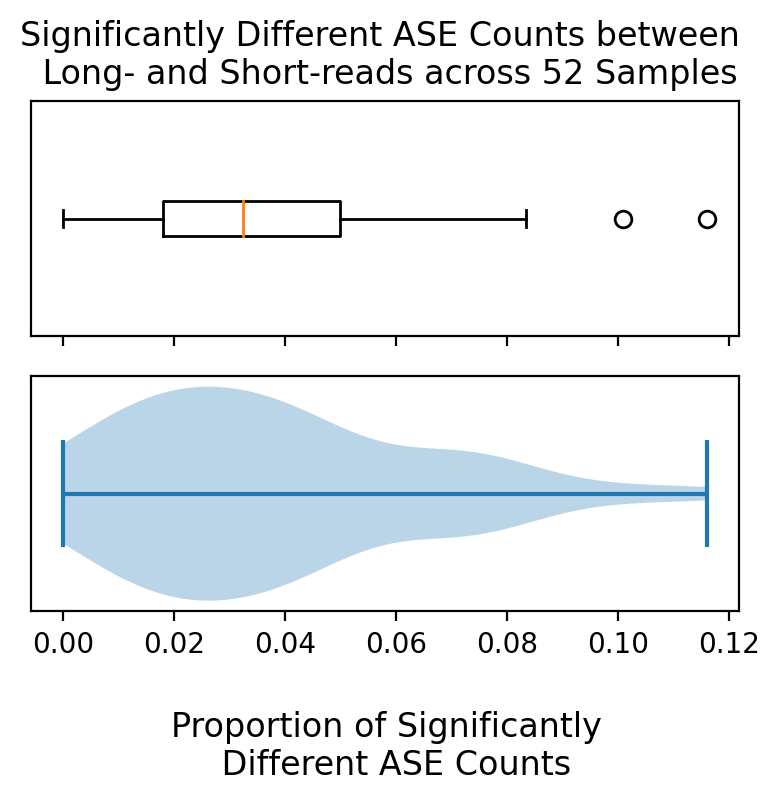

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(4, 4), dpi=200)

axes[0].boxplot(pd.Series(sig_df.SIG/sig_df.TOTAL), vert=False)
axes[0].set_yticks([])
axes[0].set_xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], [])
axes[0].set_title("Significantly Different ASE Counts between \n Long- and Short-reads across 52 Samples")
#axes[0].set_xlim(0.2, 0.8)

axes[1].violinplot(pd.Series(sig_df.SIG/sig_df.TOTAL), vert=False)
axes[1].set_yticks([])

violin_ticks = axes[1].get_xticks()
violin_lim = axes[1].get_xlim()

axes[0].set_xticks(violin_ticks)
axes[0].set_xlim(violin_lim)
#axes[1].set_xlim(0.2, 0.8)

fig.supxlabel("Proportion of Significantly \n Different ASE Counts")

plt.tight_layout()
plt.savefig("sigASE_box_violin.jpg", dpi=500)
plt.show()

In [26]:
(sig_df.SIG/sig_df.TOTAL).describe()

count    52.000000
mean      0.037585
std       0.026652
min       0.000000
25%       0.017999
50%       0.032368
75%       0.049861
max       0.116071
dtype: float64

In [21]:
(sig_df.SIG / sig_df.TOTAL).mean()

0.3037620387598147

In [121]:
df = pd.read_csv("./data/shortReadMapped/GTEX-11TTK-BRNPTM_variant_isospec.csv").dropna()

is_vars = df[(df.ALT_COUNT == 0) | (df.REF_COUNT == 0)]

In [122]:
from scipy import stats

In [64]:
df

CHR        POS TISSUE_ID  COUNT  ALT_COUNT  REF_COUNT  \
15     chr1    1000112    BRNPTM     31         11         20   
64     chr1    1599234    BRNPTM     32         19         13   
78     chr1    1735370    BRNPTM     11          4          7   
84     chr1    1915022    BRNPTM      9          3          6   
109    chr1    2395373    BRNPTM      8          2          6   
...     ...        ...       ...    ...        ...        ...   
26862  chr9  137463396    BRNPTM     14          5          9   
26868  chr9  137575667    BRNPTM     22         14          8   
26870  chr9  137587432    BRNPTM     15          3         12   
26871  chr9  137587494    BRNPTM     20          8         12   
26873  chr9  137613028    BRNPTM     29          9         20   

               GENE_ID    TRANSCRIPT_ID  
15     ENSG00000188290  ENST00000428771  
64     ENSG00000228594  ENST00000422725  
78     ENSG00000215790  ENST00000475229  
84     ENSG00000169885  ENST00000307786  
109    ENSG00000157916  ENST00000488353  
...                ...              ...  
26862  ENSG00000130653  ENST00000492278  
26868  ENSG00000148399  ENST00000491359  
26870  ENSG00000165724  ENST00000471957  
26871  ENSG00000165724  ENST00000471957  
26873  ENSG00000197070  ENST00000461627  

[5873 rows x 8 columns]

In [65]:
df["PVALUE"] = df.apply(lambda x: stats.binom_test(x.REF_COUNT, x.COUNT), axis=1)

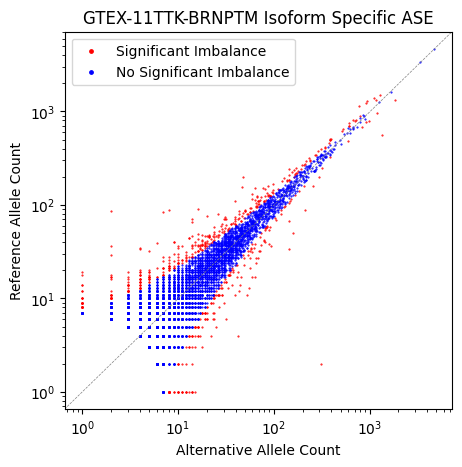

In [70]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

ax.set_xscale("log")
ax.set_yscale("log")

ax.scatter(df[df.PVALUE <= 0.05].ALT_COUNT, df[df.PVALUE <= 0.05].REF_COUNT, s=0.25, c="red", label="Significant Imbalance")
ax.scatter(df[df.PVALUE > 0.05].ALT_COUNT, df[df.PVALUE > 0.05].REF_COUNT, s=0.25, c="blue", label="No Significant Imbalance")

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linewidth=0.5, color="grey", linestyle="--")

ax.set_xlabel("Alternative Allele Count")
ax.set_ylabel("Reference Allele Count")
ax.set_title("GTEX-11TTK-BRNPTM Isoform Specific ASE")

lgnd = ax.legend(loc="best")
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [6]

plt.savefig("binom_test_plot.jpg", dpi=500)
plt.show()

In [10]:
def variant_annotation_or(var_df, var_ann):
    # Total counts of non-intron variants by tissue
    other_df = var_df[var_df.VARIANT_ANNOTATION != var_ann]
    other_tissue_cts = other_df.groupby("TISSUE_ID").size()
    
    # Counts of non-intron variants with monoallelic expression
    mono_other_df = other_df[(other_df.ALT_COUNT == 0) | (other_df.REF_COUNT == 0)]
    mono_other_tissue_cts = mono_other_df.groupby("TISSUE_ID").size()
    
    # Total counts of intron variants by tissue
    intvar_df = var_df[var_df.VARIANT_ANNOTATION == var_ann]
    intvar_tissue_cts = intvar_df.groupby("TISSUE_ID").size()
    
    # Counts of intron variants with monoallelic expression
    mono_df = intvar_df[(intvar_df.ALT_COUNT == 0) | (intvar_df.REF_COUNT == 0)]
    mono_tissue_cts = mono_df.groupby("TISSUE_ID").size()

    tdf = pd.DataFrame({
        "intron_MA": mono_tissue_cts, "intron_BA": intvar_tissue_cts - mono_tissue_cts,
        "other_MA": mono_other_tissue_cts, "other_BA": other_tissue_cts - mono_other_tissue_cts
    })
    
    # Odds Ratio
    or_series = tdf.apply(lambda x: (x.intron_MA*x.other_BA) / (x.intron_BA*x.other_MA), axis=1)
    
    return or_series

In [11]:
samples = pd.read_csv('./data/long_read_samples_short.csv')
only_pc_transcs = pd.read_csv("./data/protein_coding_transcripts.csv").rename(columns={"gene_id": "GENE_ID", "transcript_id": "TRANSCRIPT_ID"})

In [12]:
# Initialize dictionary for all variant annotations
ex_df = pd.read_csv(f"./GTEx_Analysis_v8_ASE_counts_by_subject/GTEX-12WSD.v8.ase_table.tsv", sep="\t")
var_anns = list(set(ex_df.VARIANT_ANNOTATION.dropna()))

or_dict = {x: [] for x in var_anns}

In [ ]:
for subj_id in tqdm(samples["SUBJECT_ID"]):
    try:
        base_ase = pd.read_csv(f"./GTEx_Analysis_v8_ASE_counts_by_subject/{subj_id}.v8.ase_table.tsv", sep="\t")
    except FileNotFoundError:
        continue
    
    var_df = base_ase[["VARIANT_ID", "TISSUE_ID", "VARIANT_ANNOTATION", "REF_COUNT", "ALT_COUNT", "GENE_ID"]].drop_duplicates().dropna()
    
    for var_ann in var_anns:
        or_series = variant_annotation_or(var_df, var_ann)
        or_dict[var_ann].append(or_series.median())

In [14]:
or_df = pd.DataFrame.from_dict(or_dict)

# Sort by mean odds ratio
or_df = or_df[or_df.columns[or_df.mean().argsort()[::-1]]]

In [15]:
or_df_p = or_df.drop(["mature_miRNA_variant", "coding_sequence_variant"], axis=1)

In [19]:
or_df_p = np.log10(or_df_p)

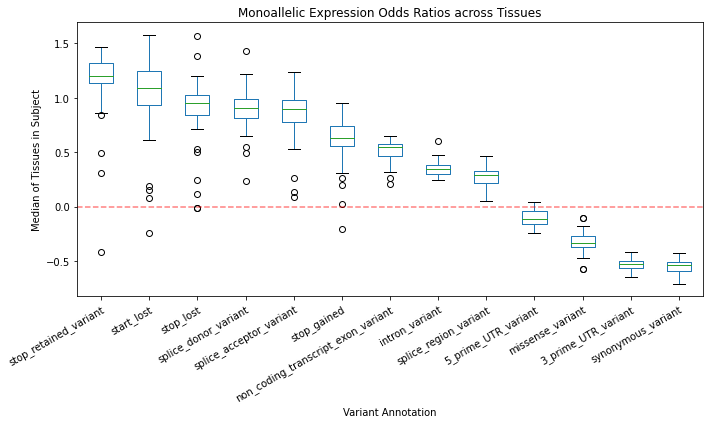

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

or_df_p.boxplot(ax=ax, grid=False)
ax.set_xticks(np.arange(or_df_p.shape[1])+1, or_df_p.columns)
ax.axhline(y=0, c="red", linestyle="--", alpha=0.5)

plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

ax.set_xlabel("Variant Annotation")
ax.set_ylabel("Median of Tissues in Subject")
ax.set_title("Monoallelic Expression Odds Ratios across Tissues")

plt.tight_layout()
plt.savefig("MonoAllelic_OR.jpg", dpi=500)
plt.show()

In [ ]:
samples = pd.read_csv('./data/long_read_samples_short.csv')
only_pc_transcs = pd.read_csv("./data/protein_coding_transcripts.csv").rename(columns={"gene_id": "GENE_ID", "transcript_id": "TRANSCRIPT_ID"})

all_is_groups = []
all_oa_groups = []
for subj_id, tissue_id in tqdm(zip(samples["SUBJECT_ID"], samples["TISSUE_ID"])):
    # Load in isoform specific variant tables
    try:
        df = pd.read_csv(f"./data/shortReadMapped/{subj_id}-{tissue_id}_variant_isospec.csv").dropna()
        df = df.merge(only_pc_transcs, how="inner")
        is_vars = df[(df.ALT_COUNT == 0) | (df.REF_COUNT == 0)]
    except FileNotFoundError:
        continue
        
    # Load in all variants
    base_ase = pd.read_csv(f"./GTEx_Analysis_v8_ASE_counts_by_subject/{subj_id}.v8.ase_table.tsv", sep="\t")
    st_df = base_ase[(base_ase.TISSUE_ID == tissue_id)]
    var_df = st_df[["CHR", "POS", "REF_COUNT", "ALT_COUNT", "GENE_ID", "VARIANT_ANNOTATION"]]
    all_vars = var_df[(var_df.REF_COUNT == 0) | (var_df.ALT_COUNT == 0)]
    
    all_is_groups.append(is_vars.merge(all_vars).groupby("VARIANT_ANNOTATION").size().reset_index().rename(columns={0: "NUM_VARIANTS"}))
    all_oa_groups.append(all_vars.groupby("VARIANT_ANNOTATION").size().reset_index().rename(columns={0: "NUM_VARIANTS"}))

is_concat = pd.concat(all_is_groups)
oa_concat = pd.concat(all_oa_groups)

is_gb = is_concat.groupby("VARIANT_ANNOTATION")
oa_gb = oa_concat.groupby("VARIANT_ANNOTATION")

sort_is_grps = is_gb.size().sort_values(ascending=False).index
sort_oa_grps = oa_gb.size().sort_values(ascending=False).index

In [128]:
all_oa_groups_perc = []
all_is_groups_perc = []
for i in range(len(all_oa_groups)):
    adj_oa = all_oa_groups[i].copy()
    adj_is = all_is_groups[i].copy()
    
    adj_is["NUM_VARIANTS"] = adj_is.NUM_VARIANTS/sum(adj_oa.NUM_VARIANTS)
    adj_oa["NUM_VARIANTS"] = adj_oa.NUM_VARIANTS/sum(adj_oa.NUM_VARIANTS)
    
    all_oa_groups_perc.append(adj_oa)
    all_is_groups_perc.append(adj_is)
        
is_perc_concat = pd.concat(all_is_groups_perc)
oa_perc_concat = pd.concat(all_oa_groups_perc)

In [130]:
is_perc_gb = is_perc_concat.groupby("VARIANT_ANNOTATION")
oa_perc_gb = oa_perc_concat.groupby("VARIANT_ANNOTATION")

sort_is_perc_grps = is_perc_gb.size().sort_values(ascending=False).index
sort_oa_perc_grps = oa_perc_gb.size().sort_values(ascending=False).index

In [93]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

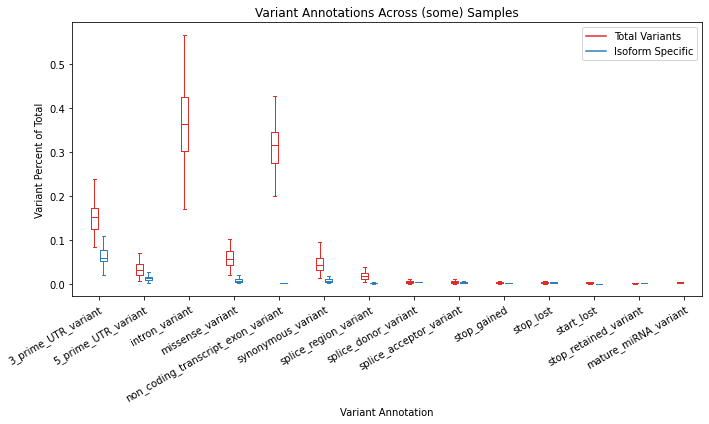

In [133]:
fig, ax = plt.subplots(figsize=(10, 6))

pos_ct = 0
for grping in sort_oa_perc_grps:
    grp_oa = oa_perc_gb.get_group(grping)
    bp1 = ax.boxplot(grp_oa["NUM_VARIANTS"], showfliers=False, positions=[pos_ct-0.1])
    set_box_color(bp1, '#de2d26')

    try:
        grp_is = is_perc_gb.get_group(grping)
        bp2 = ax.boxplot(grp_is["NUM_VARIANTS"], showfliers=False, positions=[pos_ct+0.1])
        set_box_color(bp2, '#2c7fb8')

    except KeyError:
        pass
    
    pos_ct += 1

ax.set_xticks(np.arange(len(oa_perc_gb)), sort_oa_perc_grps)
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

ax.plot([], c='#de2d26', label='Total Variants')
ax.plot([], c='#2c7fb8', label='Isoform Specific')

# ax.set_yscale("log")
plt.legend(loc="best")

ax.set_xlabel("Variant Annotation")
ax.set_ylabel("Variant Percent of Total")
ax.set_title("Variant Annotations Across (some) Samples")

plt.tight_layout()
plt.show()

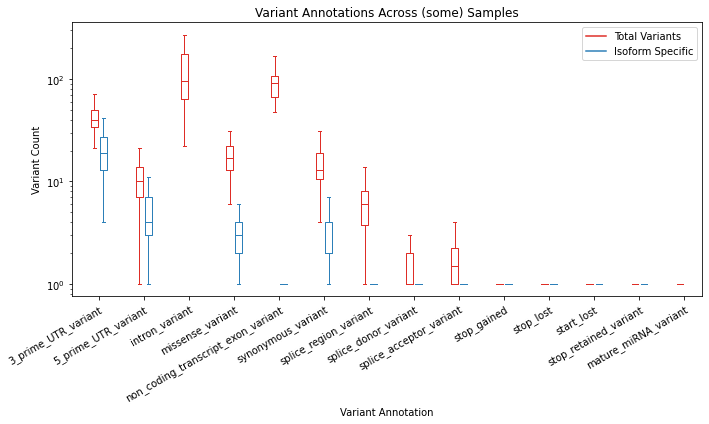

In [177]:
fig, ax = plt.subplots(figsize=(10, 6))

pos_ct = 0
for grping in sort_oa_grps:
    grp_oa = oa_gb.get_group(grping)
    bp1 = ax.boxplot(grp_oa["NUM_VARIANTS"], showfliers=False, positions=[pos_ct-0.1])
    set_box_color(bp1, '#de2d26')

    try:
        grp_is = is_gb.get_group(grping)
        bp2 = ax.boxplot(grp_is["NUM_VARIANTS"], showfliers=False, positions=[pos_ct+0.1])
        set_box_color(bp2, '#2c7fb8')

    except KeyError:
        pass
    
    pos_ct += 1

ax.set_xticks(np.arange(len(oa_gb)), sort_oa_grps)
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

ax.plot([], c='#de2d26', label='Total Variants')
ax.plot([], c='#2c7fb8', label='Isoform Specific')

ax.set_yscale("log")
plt.legend(loc="best")

ax.set_xlabel("Variant Annotation")
ax.set_ylabel("Variant Count")
ax.set_title("Variant Annotations Across (some) Samples")

plt.tight_layout()
plt.show()

In [19]:
all_is = all_is.groupby('VARIANT_ANNOTATION').sum().reset_index()
all_oa = all_oa.groupby('VARIANT_ANNOTATION').sum().reset_index()

In [20]:
vdf = all_oa.merge(all_is, on="VARIANT_ANNOTATION", suffixes=("_OA", "_IS"), how="outer").sort_values("NUM_VARIANTS_OA")

## Haplotype-level Genotyping Error Analysis

In [205]:
hap_df = pd.read_csv("./data/hap_data.tsv", sep="\t", usecols=range(10))
hap_df

#contig               name  start   stop GTEX-14A6H-2726-SM-5QGPL  \
0        chr1  ENSG00000223972.5  11868  14403                      0|0   
1        chr1  ENSG00000227232.5  14409  29553                    48|14   
2        chr1  ENSG00000278267.1  17368  17436                      0|0   
3        chr1  ENSG00000243485.5  29570  31109                      0|0   
4        chr1  ENSG00000237613.2  34553  36081                      0|0   
...       ...                ...    ...    ...                      ...   
56195    chrM  ENSG00000198695.2  14148  14673                      0|0   
56196    chrM  ENSG00000210194.1  14673  14742                      0|0   
56197    chrM  ENSG00000198727.2  14746  15887                      0|0   
56198    chrM  ENSG00000210195.2  15887  15953                      0|0   
56199    chrM  ENSG00000210196.2  15955  16023                      0|0   

      GTEX-14A6H-0226-SM-5Q5DX GTEX-14A6H-2426-SM-5Q5BO  \
0                          0|0                      0|0   
1                       103|14                   185|46   
2                          0|0                      0|0   
3                          0|0                      0|0   
4                          0|0                      0|0   
...                        ...                      ...   
56195                      0|0                      0|0   
56196                      0|0                      0|0   
56197                      0|0                      0|0   
56198                      0|0                      0|0   
56199                      0|0                      0|0   

      GTEX-14A6H-2026-SM-5Q5DD GTEX-14A6H-0526-SM-5NQAZ  \
0                          0|0                      0|0   
1                       155|42                   180|32   
2                          0|0                      0|0   
3                          0|0                      0|0   
4                          0|0                      0|0   
...                        ...                      ...   
56195                      0|0                      0|0   
56196                      0|0                      0|0   
56197                      0|0                      0|0   
56198                      0|0                      0|0   
56199                      0|0                      0|0   

      GTEX-14A6H-0006-SM-5NQ7W  
0                          0|0  
1                        63|11  
2                          0|0  
3                          0|0  
4                          0|0  
...                        ...  
56195                      0|0  
56196                      0|0  
56197                      0|0  
56198                      0|0  
56199                      0|0  

[56200 rows x 10 columns]

In [206]:
def monoallelic(in_str):
    split_arr = np.array(in_str.split("|")).astype(int)
    if sum(split_arr) == 0:
        return False
    return (split_arr[0] * split_arr[1]) == 0

In [ ]:
start = time.time()
in_str = "0|5"
print(time.time() - start)

In [207]:
hap_df["name"] = hap_df["name"].str.split(".").str[0]

In [208]:
gtex_cols = [x for x in hap_df.columns if "GTEX" in x]

In [187]:
sdf = pd.read_csv("./data/short_read_subject_tissue.csv")

In [237]:
pd.set_option('display.max_rows', 500)

In [202]:
tiss_id, sample_id, subj_id = sdf[sdf.SAMPLE_ID == gtex_cols[0]].iloc[0]

In [ ]:
vdf = pd.read_csv(f"./GTEx_Analysis_v8_ASE_counts_by_subject/{subj_id}.v8.ase_table.tsv", sep="\t")
vdf = vdf[vdf.TISSUE_ID == tiss_id]
vdf

NameError: name 'tiss_id' is not defined

In [241]:
vdf[vdf.GENE_ID == "ENSG00000142794"]

Empty DataFrame
Columns: [CHR, POS, VARIANT_ID, REF_ALLELE, ALT_ALLELE, SAMPLE_ID, SUBJECT_ID, TISSUE_ID, REF_COUNT, ALT_COUNT, TOTAL_COUNT, REF_RATIO, OTHER_ALLELE_COUNT, NULL_RATIO, BINOM_P, BINOM_P_ADJUSTED, MAMBA_POST_SINGLETIS, MAMBA_POST_MULTITIS, GENOTYPE, VARIANT_ANNOTATION, GENE_ID, LOW_MAPABILITY, MAPPING_BIAS_SIM, GENOTYPE_WARNING]
Index: []

## Discordant ASE EDA

In [70]:
vdf = pd.read_csv("./GTEx_Analysis_v8_ASE_counts_by_subject/GTEX-12WSD.v8.ase_table.tsv", sep="\t")

vdf = vdf[vdf.TISSUE_ID == "MSCLSK"]

vdf_nvars = vdf.groupby("GENE_ID").size()

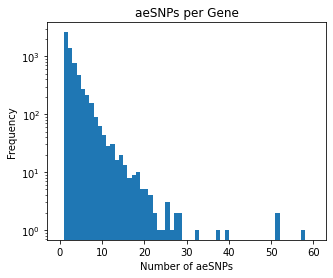

In [73]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(vdf_nvars, bins=np.arange(0, vdf_nvars.max()))
ax.set_yscale("log")

ax.set_title("aeSNPs per Gene")
ax.set_xlabel("Number of aeSNPs")
ax.set_ylabel("Frequency")

plt.show()

In [74]:
# Case study: ENSG00000283186 (27 aeSNPs)
gene_df = vdf[vdf.GENE_ID == "ENSG00000283186"]

In [54]:
pc_pri = pd.read_csv("./data/pc_exon_region_classification2.csv")

In [80]:
def df_chunker(full_df, chunks):
    dfs = list()
    interval_size = full_df.shape[0]//chunks
    dfs.append(full_df.iloc[0:interval_size, :])

    for i in range(chunks - 1):
        dfs.append(full_df.iloc[(interval_size * (i + 1))
                   :(interval_size * (i + 2)), :])

    if full_df.shape[0] % chunks != 0:
        dfs.append(full_df.iloc[interval_size * chunks:, :])

    return dfs


# pri_table: table of ranges to which pos are assessed on
def in_range(pos, chrom, pri_table):
    sub_pri = pri_table[pri_table.seqname == chrom]
    starts = sub_pri["start"]
    ends = sub_pri["end"]
    
    in_ends = (ends - pos) >= 0
    in_starts = (pos - starts) >= 0
    
    between = (in_ends * in_starts)
    between = np.where(between)[0]
    if len(between) == 0:
        return None, None
    between = sub_pri.iloc[between]

    return between["gene_id"].item(), between["transcript_ids"].item()


def pos_transc_mapper(sub_df, pri_table):
    pos_tgs = sub_df[["CHR", "POS"]].apply(lambda x: in_range(x.POS, x.CHR, pri_table), axis=1)
    pos_gene_ids = [x[0] for x in pos_tgs]
    pos_tran_ids = [x[1] for x in pos_tgs]

    ret_df = sub_df.copy()
    ret_df["GENE_ID"] = pos_gene_ids
    ret_df["TRANSCRIPT_ID"] = pos_tran_ids
    
    return sub_df

In [87]:
# Maps positions to transcripts according to reference df
def pt_mapper(vdf, ref_df, chunks=0):
    if chunks != 0:
        sdf_chunks = df_chunker(vdf, 20)
        out_dfs = Parallel(n_jobs=-1)(delayed(pos_transc_mapper)(sdf_chunk, ref_df) for sdf_chunk in sdf_chunks)
        ret_df = pd.concat(out_dfs, axis=0)

    else:
        ret_df = pos_transc_mapper(vdf, ref_df)
    
    return ret_df


vdf_mapped = pt_mapper(gene_df, pc_pri)

In [24]:
tdf = pd.read_csv("./data/pc_exon_region_classification2.csv")
tdf[tdf.gene_id == "ENSG00000127472"]

seqname     start       end  transcript_count  max_transcripts  \
10539    chr1  20028179  20028429               1.0              6.0   
10540    chr1  20028430  20028433               2.0              6.0   
10541    chr1  20028434  20028525               3.0              6.0   
10542    chr1  20028526  20028570               5.0              6.0   
10543    chr1  20028571  20028709               6.0              6.0   
10562    chr1  20046102  20046141               1.0              1.0   
10572    chr1  20054792  20054839               1.0              1.0   
10588    chr1  20059632  20059692               6.0              6.0   
10598    chr1  20063484  20063602               1.0              1.0   
10604    chr1  20066024  20066129               1.0              1.0   
10619    chr1  20068873  20069032               6.0              6.0   
10620    chr1  20069033  20069034               1.0              6.0   
10642    chr1  20070208  20070293               1.0              5.0   
10643    chr1  20070294  20070294               4.0              5.0   
10644    chr1  20070295  20070414               5.0              5.0   
10645    chr1  20070415  20070465               4.0              5.0   
10659    chr1  20070845  20070944               1.0              1.0   
10667    chr1  20076761  20076898               1.0              1.0   
10678    chr1  20084821  20084870               7.0              7.0   
10688    chr1  20086083  20086227               7.0              7.0   
10697    chr1  20088825  20088901               2.0              2.0   
10698    chr1  20088902  20088943               1.0              2.0   
10712    chr1  20089789  20089895               6.0              6.0   
10728    chr1  20090568  20090780               5.0              5.0   
10729    chr1  20090781  20090828               4.0              5.0   
10730    chr1  20090829  20091158               3.0              5.0   
10731    chr1  20091159  20091168               2.0              5.0   
10732    chr1  20091169  20091190               1.0              5.0   

               gene_id                                     transcript_ids  
10539  ENSG00000127472                                    ENST00000486277  
10540  ENSG00000127472                    ENST00000486277;ENST00000465698  
10541  ENSG00000127472    ENST00000486277;ENST00000465698;ENST00000460175  
10542  ENSG00000127472  ENST00000486277;ENST00000465698;ENST0000046017...  
10543  ENSG00000127472  ENST00000486277;ENST00000465698;ENST0000046017...  
10562  ENSG00000127472                                    ENST00000486277  
10572  ENSG00000127472                                    ENST00000486277  
10588  ENSG00000127472  ENST00000486277;ENST00000465698;ENST0000046017...  
10598  ENSG00000127472                                    ENST00000469069  
10604  ENSG00000127472                                    ENST00000486277  
10619  ENSG00000127472  ENST00000486277;ENST00000465698;ENST0000046017...  
10620  ENSG00000127472                                    ENST00000498348  
10642  ENSG00000127472                                    ENST00000375108  
10643  ENSG00000127472  ENST00000460175;ENST00000489871;ENST0000049834...  
10644  ENSG00000127472  ENST00000460175;ENST00000489871;ENST0000049834...  
10645  ENSG00000127472  ENST00000460175;ENST00000489871;ENST0000037510...  
10659  ENSG00000127472                                    ENST00000460175  
10667  ENSG00000127472                                    ENST00000478803  
10678  ENSG00000127472  ENST00000486277;ENST00000465698;ENST0000046017...  
10688  ENSG00000127472  ENST00000486277;ENST00000465698;ENST0000046017...  
10697  ENSG00000127472                    ENST00000465698;ENST00000478803  
10698  ENSG00000127472                                    ENST00000465698  
10712  ENSG00000127472  ENST00000486277;ENST00000465698;ENST0000046906...  
10728  ENSG00000127472  ENST00000486277;ENST00000465698;ENST0000048987...  
10729  ENSG000001

In [38]:
# Creates exon_region_classification

import pandas as pd
import numpy as np
import os
import itertools
from joblib import Parallel, delayed
from operator import itemgetter


def df_chunker(full_df, chunks):
    dfs = list()
    interval_size = full_df.shape[0]//chunks
    dfs.append(full_df.iloc[0:interval_size, :])

    for i in range(chunks - 1):
        dfs.append(full_df.iloc[(interval_size * (i + 1))
                   :(interval_size * (i + 2)), :])

    if full_df.shape[0] % chunks != 0:
        dfs.append(full_df.iloc[interval_size * chunks:, :])

    return dfs


def inter_ranges(intersect_counts, start_bp):
    counts = []
    cons_counts = [0]
    for count, it in itertools.groupby(intersect_counts):
        counts.append(count)
        cons_counts.append(len(list(it)))

    bp_is = np.cumsum(cons_counts) + start_bp

    ranges = np.lib.stride_tricks.sliding_window_view(bp_is, 2).copy()
    ranges[:, 1] = ranges[:, 1] - 1
    
    return counts, ranges


def get_transc_id(exon_df, bp_range):
    rstart, rend = bp_range
    ol_df = exon_df[(exon_df["start"] <= rstart) & (exon_df["end"] >= rend)]
    transc_ids = ";".join(ol_df["transcript_id"])
    return transc_ids
        

def range_classifier(model_exon_chunk):
    for i in range(10):
        model_row = model_exon_chunk.iloc[i]
        # Get model data
        gene_id = model_row["gene_id"]
        chrom = model_row["seqname"]

        # Standardize ranges to be indices as well
        model_exon_range = np.arange(model_row["start"], model_row["end"] + 1) - model_row["start"]

        # Limit searching ranges to just same gene
        gene_exons = pri_exons[pri_exons["gene_id"] == gene_id]
        max_transcs = len(set(gene_exons.transcript_id))

        # Maintain number of isoforms overlapping with model exons' regions
        intersect_counts = np.zeros(len(model_exon_range))
        for j in range(gene_exons.shape[0]):
            pri_row = gene_exons.iloc[j]
            pri_exon_range = np.arange(pri_row["start"], pri_row["end"] + 1) - model_row["start"]
            intersection = np.intersect1d(model_exon_range, pri_exon_range)

            intersect_counts[intersection] = intersect_counts[intersection] + 1

        counts, ranges = inter_ranges(intersect_counts, model_row["start"])
        t_ids = [get_transc_id(gene_exons, x) for x in ranges]

        starts = list(map(itemgetter(0), ranges))
        ends = list(map(itemgetter(1), ranges))

        max_counts = [max_transcs] * len(counts)
        gene_ids = [model_row["gene_id"]] * len(counts)
        chroms = [model_row["seqname"]] * len(counts)

        dat_df = pd.DataFrame({"seqname":chroms, "start": starts, "end": ends, "transcript_count": counts, "max_transcripts": max_counts, "gene_id": gene_ids, "transcript_ids": t_ids})

        # dat_df.to_csv("./data/pc_exon_region_classification2.csv", mode='a', index=False, header=not os.path.exists("./data/pc_exon_region_classification2.csv"))

In [31]:
if __name__ == "__main__":
    model_exons = pd.read_csv("./data/pcModelExons.csv")
    pri_exons = pd.read_csv("./data/pcPriExons.csv")
    
    #chunks = df_chunker(model_exons, 100)

    #par_out = Parallel(n_jobs=-1)(delayed(range_classifier)(mec) for mec in chunks)

In [35]:
model_exons.iloc[:10]

seqname  source feature   start     end score strand frame          gene_id  \
0    chr1  HAVANA    exon   69091   70008     .      +     .  ENSG00000186092   
1    chr1  HAVANA    exon  450740  451678     .      -     .  ENSG00000278566   
2    chr1  HAVANA    exon  685716  686654     .      -     .  ENSG00000273547   
3    chr1  HAVANA    exon  923928  924948     .      +     .  ENSG00000187634   
4    chr1  HAVANA    exon  925150  925189     .      +     .  ENSG00000187634   
5    chr1  HAVANA    exon  925738  925800     .      +     .  ENSG00000187634   
6    chr1  HAVANA    exon  925922  926013     .      +     .  ENSG00000187634   
7    chr1  HAVANA    exon  930155  930336     .      +     .  ENSG00000187634   
8    chr1  HAVANA    exon  931039  931089     .      +     .  ENSG00000187634   
9    chr1  HAVANA    exon  935772  935896     .      +     .  ENSG00000187634   

     transcript_id       gene_type gene_name transcript_type transcript_name  \
0  ENSG00000186092  protein_coding     OR4F5  protein_coding           OR4F5   
1  ENSG00000278566  protein_coding    OR4F29  protein_coding          OR4F29   
2  ENSG00000273547  protein_coding    OR4F16  protein_coding          OR4F16   
3  ENSG00000187634  protein_coding    SAMD11  protein_coding          SAMD11   
4  ENSG00000187634  protein_coding    SAMD11  protein_coding          SAMD11   
5  ENSG00000187634  protein_coding    SAMD11  protein_coding          SAMD11   
6  ENSG00000187634  protein_coding    SAMD11  protein_coding          SAMD11   
7  ENSG00000187634  protein_coding    SAMD11  protein_coding          SAMD11   
8  ENSG00000187634  protein_coding    SAMD11  protein_coding          SAMD11   
9  ENSG00000187634  protein_coding    SAMD11  protein_coding          SAMD11   

   level          exon_id  exon_number  
0      2  ENSG00000186092            1  
1      2  ENSG00000278566            1  
2      2  ENSG00000273547            1  
3      2  ENSG00000187634            1  
4      2  ENSG00000187634            2  
5      2  ENSG00000187634            3  
6      2  ENSG00000187634            4  
7      2  ENSG00000187634            5  
8      2  ENSG00000187634            6  
9      2  ENSG00000187634            7